In [4]:

from sys import argv
import time
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import matplotlib.pyplot as plt
from pyrap.tables import table 
import astropy.io.fits as fits
from astropy import wcs
from pyuvdata import UVBeam
import os
import sys
import glob
import argparse
import shutil
import copy
import healpy
import scipy.stats as stats
import datetime
import ephem
from scipy import interpolate
from astropy.time import Time
import pylab as plt
from astropy.table import Table
from scipy import signal
plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels

In [5]:
def closure_phase(msfile_used,triad_list): 
    import numpy as np
    from pyrap.tables import table
    
    msfile=table(msfile_used,readonly=True)
    data=msfile.getcol("DATA")[:,:,0]
    ant_i=msfile.getcol("ANTENNA1")
    ant_j=msfile.getcol("ANTENNA2")
    V_ij=data[bl_finder(ant_i,ant_j,triad_list[0],triad_list[1])]
    V_jk=data[bl_finder(ant_i,ant_j,triad_list[1],triad_list[2])]
    V_ki=np.conjugate(data[bl_finder(ant_i,ant_j,triad_list[0],triad_list[2])])
    bispectrum=V_ij*V_jk*V_ki
    closure_phase=np.angle(bispectrum)
    return closure_phase, V_ij
def bl_finder (ant_i,ant_j,i,j):
        
           
           y=np.where((ant_i==i)&(ant_j==j))
        
           return y
        

def closure_proj (data_x,triad):
    
    cl,b1=closure_phase(data_x,triad[0])
    x1=cl[0,628:628+280]
    cl2,b2=closure_phase(data_x,triad[1])
    x2=cl2[0,628:628+280]
    cl_p1=np.exp(1.0j*x1)
    cl_p2=np.exp(1.0j*x2)
    return cl_p1,cl_p2



from astropy.cosmology import FlatLambdaCDM 
cosmo = FlatLambdaCDM(H0=100, Om0=0.308)
def k_II(tau,B_eff,z,H0):
    
    numerator=2.0*np.pi*tau*B_eff

    return (numerator/Delta_D(z,B_eff))
def Delta_D(z,B_eff):
    f_12=1420.4e6
    c_km=3e5 #km/s
    H0=cosmo.H0
    D=((c_km*(1+z)**2)*B_eff)/(H0*f_12*E(z))
    return D
def E(z):
    Omega_k=0
    Omega_M=0.308 
    Omega_lamda=1-Omega_M
    E=(Omega_M*(1+z)**3+Omega_k*(1+z)**2+Omega_lamda)**(0.5)
    return E

def fft(v, W=None, norm=None, inverse=False, shift=False, axis=-1):
    """Compute FFT

    Args:
        v (array): input data
        W (array): window function. Defaults to None.
        norm (str): normalisation (None or "ortho"). Defaults to None.
        inverse (bool): If True, perform inverse FFT. Defaults to False.
        shift (bool): If True, shift FFT to centre. Defaults to False.
        aixs (int): axis along which to compute fourier transform. Defaults to -1.

    Returns:
        array: Fourier transformed data
    """

    v = np.moveaxis(v, axis, -1)

    # generate boxcar window
    if W is None:
        W = np.ones(v.shape[-1])

    # compute inverse FFT
    if inverse:
        ft = np.fft.ifft(W * v, axis=-1, norm=norm)

        # shift FFT to centre
        if shift:
            ft = np.fft.ifftshift(ft, axes=-1)

    # compute FFT
    else:
        ft = np.fft.fft(W * v, axis=-1, norm=norm)

        # shift FFT to centre
        if shift:
            ft = np.fft.fftshift(ft, axes=-1)

    return np.moveaxis(ft, -1, axis)


def xpspec(
    v1, v2, fs=1, W=None, norm=None, inverse=False, shift=False, return_phase=False
):
    """Compute FFT Cross-Power Spectrum

    Args:
        v1 (array): input array 1
        v2 (array): input array 2
        fs (float): sampling frequency. Defaults to 1.
        W (array): window function. Defaults to None.
        norm (str): normalisation (None or "ortho"). Default to None.
        inverse (bool): If True, perform inverse FFT. Defaults to False.
        shift (bool): If True, shift FFT to centre. Defaults to False.
        return_phase (bool): If True, phase of FFT is returned. Defaults to False.

    Returns:
        array: cross-power spectrum of v1 and v2
    """

    # compute FFT
    ft1 = fft(v1, W=W, norm=norm, inverse=inverse, shift=shift)
    ft2 = fft(v2, W=W, norm=norm, inverse=inverse, shift=shift)

    # normalise FFT
    ft1 = ft1 / fs
    ft2 = ft2 / fs

    # inverse normalisation
    if inverse:
        ft1 = ft1 * ft1.shape[-1]
        ft2 = ft2 * ft2.shape[-1]

    # return phase info?
    if return_phase:
        return ft1 * ft2.conjugate(), np.angle(ft1)
    else:
        return ft1 * ft2.conjugate()



In [6]:
def powerScaling(Ae=100, f0=163e6, B=10e6, verbose=False):
    """Scaling factor

    Args:
        Ae (float): effective area of antenna in m^2
        f0 (float): centre frequency of observed band in Hz
        B (float): effective bandwidth of observed band in Hz
        verbose (bool, optional): If True, will print all constituents of scaling factor. Defaults to False.

    Returns:
        float: power scaling factor
    """

    # wavelength of centre frequency in metres
    c=3.0e8
    lam = c / f0
    kb=1.38064852e-23

    # redshift corresponding to centre frequency
    f_12=1420.4e6
    freq_data=np.linspace(100,200,1024)*1e6
    F_175_Hz=175.0e6
    c=3e8
    lambda_175=(F_175_Hz/c)
    z=np.abs((freq_data[768]-f_12)/freq_data[768])
    # comoving distance at redshift z (Mpc)
    D=cosmo.comoving_transverse_distance(z=z)

    # comoving depth corresponding to centre frequency f0 and bandwidth B
    dD = Delta_D(z,B_eff)

    j1 = Ae / (lam ** 2 * B)
    j2 = D ** 2 * dD / B

    if verbose:
        print("\n")
        print("effective antenna area: {:.0f} m^2".format(Ae))
        print("centre frequency: {:.0f} Hz".format(f0))
        print("centre wavelength: {:.2f} m".format(lam))
        print("bandwidth: {:.0f} Hz".format(B))
        print("redshift: {:.1f}".format(z))
        print("comoving distance: {:.0f} Mpc/h".format(D))
        print("comoving depth: {:.0f} Mpc/h".format(dD))
        print("J1 = Ae/(lambda^2*B): {:f} Hz^-1".format(j1))
        print("J2 = D^2*dD/B: {:f} (Mpc/h)^3/Hz".format(j2))


    return   j1 * j2

In [7]:
def JytomK(Jy, f0=163e6):
    """Convert Jansky to mK

    Args:
        Jy (float): brightness in Jy
        f0 (float): frequency in Hz

    Returns:
        float: brightness temperature in mK
    """

    # wavelength in m
    c=3.0e8
    lam = c / f0

    # flux density in W/m^2/Hz
    S = Jy * 1e-26
    kb=1.38064852e-23
    # temperature in K
    T = S * lam ** 2 / (2 * kb)

    # return temperature in mK
    return T * 1e3
def Power_Spectrum_Jy_2(msfile_used, triads):
    from scipy import signal
    
    triad_list=triads[0]
    msfile=table(msfile_used,readonly=True)
    data=msfile.getcol("DATA")[:,:,0]
    ant_i=msfile.getcol("ANTENNA1")
    ant_j=msfile.getcol("ANTENNA2")
    V_ij=data[bl_finder(ant_i,ant_j,triad_list[0],triad_list[1])][0,628:628+280] # visibilities
    V_jk=data[bl_finder(ant_i,ant_j,triad_list[1],triad_list[2])][0,628:628+280]
    V_ki=np.conjugate(data[bl_finder(ant_i,ant_j,triad_list[0],triad_list[2])])[0,628:628+280]
    window = signal.blackmanharris(280)
    df=((200-100)/1024.0)*1e6

    V_ij_f=np.trapz(y=V_ij*window, dx=df)/(np.trapz(y=window,dx=df)) 
    V_jk_f=np.trapz(y=V_jk*window, dx=df)/(np.trapz(y=window,dx=df)) 
    V_ki_f=np.trapz(y=V_ki*window, dx=df)/(np.trapz(y=window,dx=df)) 


    V_eff=(np.abs(V_ij_f**(-2))+np.abs(V_jk_f**(-2))+np.abs(V_ki_f**(-2)))**(-0.5)
    A_eff=100.0
    f_12=1420.4e6
    k_b=1.38064852e-23
    freq_data=np.linspace(100,200,1024)*1e6
    F_175_Hz=175.0e6
    c=3e8
    lambda_175=(F_175_Hz/c)

    z=np.abs((freq_data[768]-f_12)/freq_data[768]) 


    B_eff=np.trapz(y=window,dx=df)
    H0=cosmo.H0
    base_line=29.2
    theta=(lambda_175/base_line)
    D=cosmo.comoving_transverse_distance(z=z)
    constant=(A_eff/(lambda_175**2*B_eff))*((D**2*Delta_D(z,B_eff))/B_eff)
    V_mk=JytomK(V_eff, f0=F_175_Hz)

    N=280
    window = signal.blackmanharris(N)
    cl1,cl2=closure_proj(msfile_used,triads)
    df=((200-100)/1024.0)*1e6
    tau=np.fft.fftshift(np.fft.fftfreq(N,d=df))
    
    phi=xpspec(v1=cl1,v2=cl2,W=window,shift=True,inverse=False)
    k_par=k_II(tau,B_eff,z,H0)
    
    
   
    
    return k_par,np.real(phi)*V_mk**2*constant*df**2,np.angle(phi)




## Analysis of cross power spectra

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/

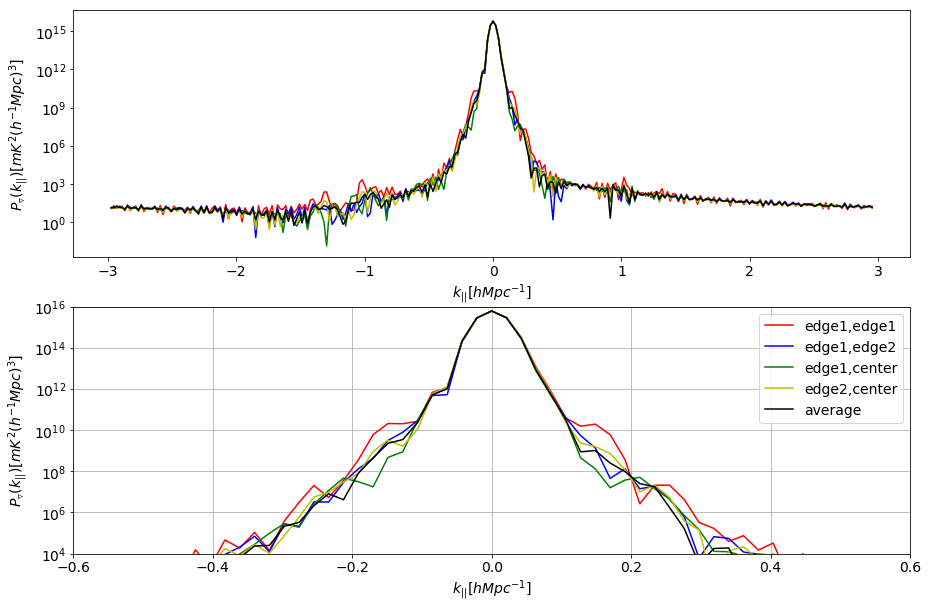

In [8]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad_EEC=[0,1,4]
triad_ECC=[2,4,6]
triad_CCC=[3,5,7]
triads=np.array([triad_ECC,triad_ECC])
triads_edge=np.array([triad_EEC,triad_ECC])
triads_center_edge=np.array([triad_EEC,triad_CCC])
triads_center_edge2=np.array([triad_ECC,triad_CCC])

k_par,Power_0h,phase0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_0h.ms",triads)
k_par2,Power2_0h,phase20h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_0h.ms",triads_edge)
k_par3,Power3_0h,phase30h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_0h.ms",triads_center_edge)
k_par3,Power4_0h,phase40h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_0h.ms",triads_center_edge2)
ave=(Power2_0h+Power3_0h+Power4_0h)/3
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.semilogy(k_par,np.abs(Power_0h),'r',label='${E_{H}E_{H}E_{H}}$')
plt.semilogy(k_par2,np.abs(Power2_0h),'b',label='${E_{22}E_{22}E_{22}}$')
plt.semilogy(k_par3,np.abs(Power3_0h),'g',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par3,np.abs(Power4_0h),'y',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par3,np.abs(ave),'k',label='${E_{26}E_{06}E_{22}}$')
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")

plt.subplot(2, 1, 2)
plt.semilogy(k_par,np.abs(Power_0h),'r',label='edge1,edge1')
plt.semilogy(k_par2,np.abs(Power2_0h),'b',label='edge1,edge2')
plt.semilogy(k_par3,np.abs(Power3_0h),'g',label='edge1,center')
plt.semilogy(k_par3,np.abs(Power4_0h),'y',label='edge2,center')
plt.semilogy(k_par3,np.abs(ave),'k',label='average')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([1e4,1e16])
plt.xlim([-0.6,0.6])
plt.grid()

Text(0,0.5,'$\\phi[radiants]$')

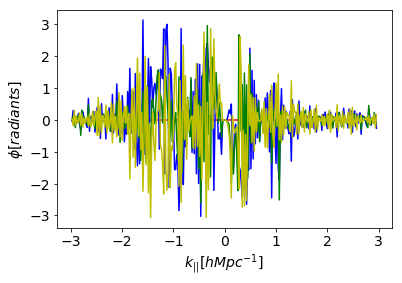

In [9]:

ave_phase=(phase0h+phase20h+phase30h+phase40h)

# plt.figure(figsize=(15,10))
plt.plot(k_par,phase0h,'r',label='edge1,edge1')
plt.plot(k_par2,phase20h,'b',label='edge1,center')
plt.plot(k_par3,phase30h,'g',label='edge1,edge2')
plt.plot(k_par3,phase40h,'y',label='edge2,center')
# plt.plot(k_par3,ave_phase,'k',label='average')
# plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$\\phi[radiants]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_05h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_05h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_05h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_05h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_05h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corrup

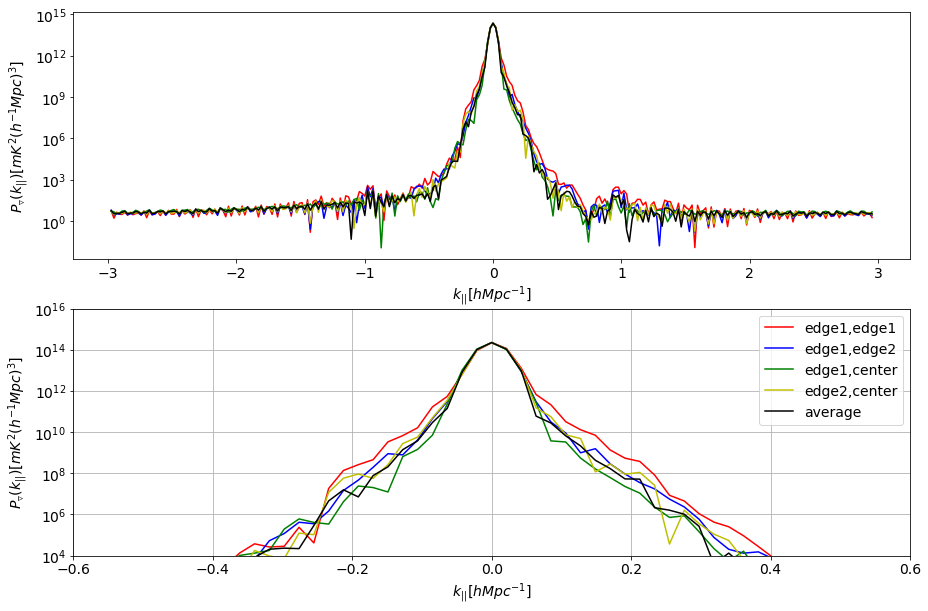

In [10]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad_EEC=[0,1,4]
triad_ECC=[2,4,6]
triad_CCC=[3,5,7]
triads=np.array([triad_ECC,triad_ECC])
triads_edge=np.array([triad_EEC,triad_ECC])
triads_center_edge=np.array([triad_EEC,triad_CCC])
triads_center_edge2=np.array([triad_ECC,triad_CCC])

k_par,Power_0h,phase0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_05h.ms",triads)
k_par2,Power2_0h,phase20h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_05h.ms",triads_edge)
k_par3,Power3_0h,phase30h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_05h.ms",triads_center_edge)
k_par3,Power4_0h,phase40h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_05h.ms",triads_center_edge2)
ave=(Power2_0h+Power3_0h+Power4_0h)/3
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.semilogy(k_par,np.abs(Power_0h),'r',label='${E_{H}E_{H}E_{H}}$')
plt.semilogy(k_par2,np.abs(Power2_0h),'b',label='${E_{22}E_{22}E_{22}}$')
plt.semilogy(k_par3,np.abs(Power3_0h),'g',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par3,np.abs(Power4_0h),'y',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par3,np.abs(ave),'k',label='${E_{26}E_{06}E_{22}}$')
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")

plt.subplot(2, 1, 2)
plt.semilogy(k_par,np.abs(Power_0h),'r',label='edge1,edge1')
plt.semilogy(k_par2,np.abs(Power2_0h),'b',label='edge1,edge2')
plt.semilogy(k_par3,np.abs(Power3_0h),'g',label='edge1,center')
plt.semilogy(k_par3,np.abs(Power4_0h),'y',label='edge2,center')
plt.semilogy(k_par3,np.abs(ave),'k',label='average')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([1e4,1e16])
plt.xlim([-0.6,0.6])
plt.grid()

Text(0,0.5,'$\\phi[radiants]$')

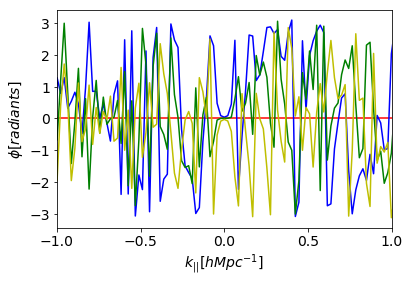

In [11]:

ave_phase=(phase0h+phase20h+phase30h+phase40h)

# plt.figure(figsize=(15,10))
plt.plot(k_par,phase0h,'r',label='edge1,edge1')
plt.plot(k_par2,phase20h,'b',label='edge1,center')
plt.plot(k_par3,phase30h,'g',label='edge1,edge2')
plt.plot(k_par3,phase40h,'y',label='edge2,center')
# plt.plot(k_par3,ave_phase,'k',label='average')
# plt.legend()
plt.xlim(-1,1)
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$\\phi[radiants]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_1h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_1h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_1h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_1h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_1h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/

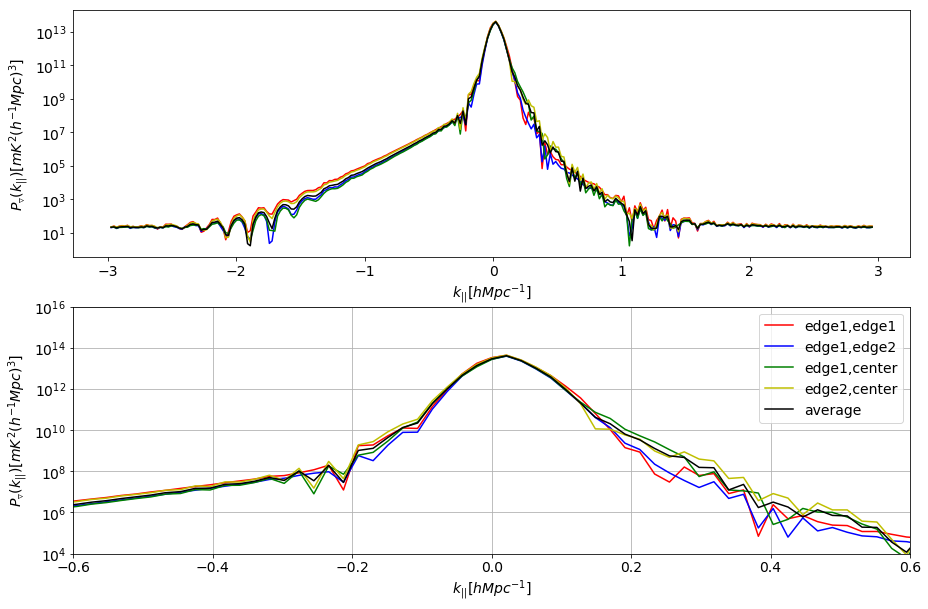

In [12]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad_EEC=[0,1,4]
triad_ECC=[2,4,6]
triad_CCC=[3,5,7]
triads=np.array([triad_ECC,triad_ECC])
triads_edge=np.array([triad_EEC,triad_ECC])
triads_center_edge=np.array([triad_EEC,triad_CCC])
triads_center_edge2=np.array([triad_ECC,triad_CCC])

k_par,Power_0h,phase0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_1h.ms",triads)
k_par2,Power2_0h,phase20h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_1h.ms",triads_edge)
k_par3,Power3_0h,phase30h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_1h.ms",triads_center_edge)
k_par3,Power4_0h,phase40h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_1h.ms",triads_center_edge2)
ave=(Power2_0h+Power3_0h+Power4_0h)/3
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.semilogy(k_par,np.abs(Power_0h),'r',label='${E_{H}E_{H}E_{H}}$')
plt.semilogy(k_par2,np.abs(Power2_0h),'b',label='${E_{22}E_{22}E_{22}}$')
plt.semilogy(k_par3,np.abs(Power3_0h),'g',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par3,np.abs(Power4_0h),'y',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par3,np.abs(ave),'k',label='${E_{26}E_{06}E_{22}}$')
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")

plt.subplot(2, 1, 2)
plt.semilogy(k_par,np.abs(Power_0h),'r',label='edge1,edge1')
plt.semilogy(k_par2,np.abs(Power2_0h),'b',label='edge1,edge2')
plt.semilogy(k_par3,np.abs(Power3_0h),'g',label='edge1,center')
plt.semilogy(k_par3,np.abs(Power4_0h),'y',label='edge2,center')
plt.semilogy(k_par3,np.abs(ave),'k',label='average')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([1e4,1e16])
plt.xlim([-0.6,0.6])
plt.grid()

Text(0,0.5,'$\\phi[radiants]$')

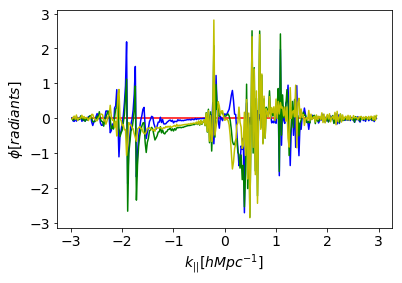

In [13]:

ave_phase=(phase0h+phase20h+phase30h+phase40h)

# plt.figure(figsize=(15,10))
plt.plot(k_par,phase0h,'r',label='edge1,edge1')
plt.plot(k_par2,phase20h,'b',label='edge1,center')
plt.plot(k_par3,phase30h,'g',label='edge1,edge2')
plt.plot(k_par3,phase40h,'y',label='edge2,center')
# plt.plot(k_par3,ave_phase,'k',label='average')
# plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$\\phi[radiants]$")

In [14]:
window = signal.blackmanharris(280)
v2=np.ones(window.shape)
ft = fft(v2, W=window, norm=None, shift=True)

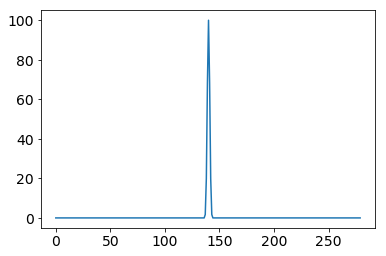

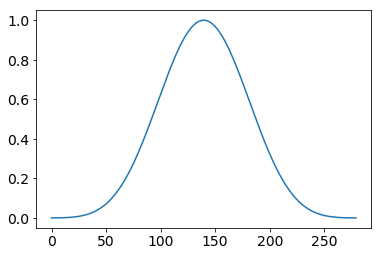

In [15]:
plt.plot((np.abs(ft)))
plt.figure()
plt.plot(window)

## mutual coupling power spectra

## Sky components power spectra

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_field_0h_Fornax.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_field_0h_GLEAM.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_field_0h_diffuse_emission.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_field_0h_Fornax.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_sim

Text(0,0.5,'$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$')

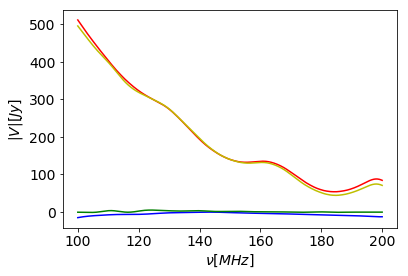

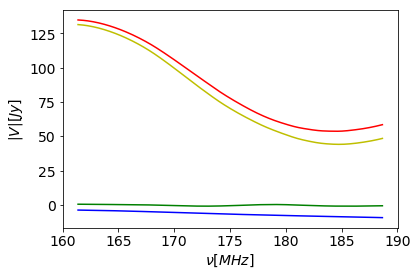

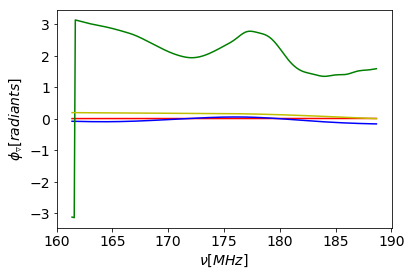

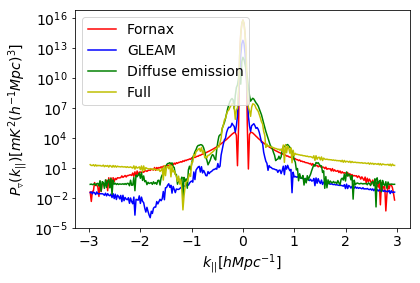

In [17]:

path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad_EEC=[0,1,4]
triad_ECC=[2,4,6]
triad_CCC=[3,5,7]

triads=np.array([triad_ECC,triad_ECC])

c1,b1=closure_phase(path_to_GLEAM+'HERA_beam_field_0h_Fornax.ms',triad_CCC)
c2,b2=closure_phase(path_to_GLEAM+'HERA_beam_field_0h_GLEAM.ms',triad_CCC)
c3,b3=closure_phase(path_to_GLEAM+'HERA_beam_field_0h_diffuse_emission.ms',triad_CCC)
c4,b4=closure_phase(path_to_GLEAM+'HERA_beam_full_0h.ms',triad_CCC)
freq=np.linspace(100,200,1024)

plt.plot(freq,b1[0,:],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq,b2[0,:],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq,b3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,b4[0,:],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$|V| [Jy]$")

plt.figure()
plt.plot(freq[628:628+280],b1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],b2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],b3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],b4[0,:][628:628+280],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$|V| [Jy]$")




plt.figure()
plt.plot(freq[628:628+280],c1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],c2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],c3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],c4[0,:][628:628+280],'y',label='$\\triangledown_{CCC}$')

plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")


k_par,Power_0h,phase=Power_Spectrum_Jy_2(path_to_GLEAM+"HERA_beam_field_0h_Fornax.ms",triads)
k_par2,Power2_0h,phase=Power_Spectrum_Jy_2(path_to_GLEAM+"HERA_beam_field_0h_GLEAM.ms",triads)
k_par3,Power3_0h,phase=Power_Spectrum_Jy_2(path_to_GLEAM+"HERA_beam_field_0h_diffuse_emission.ms",triads)
k_par4,Power4_0h,phase=Power_Spectrum_Jy_2(path_to_GLEAM+'HERA_beam_full_0h.ms',triads)

plt.figure()
plt.semilogy(k_par,Power_0h,'r',label='Fornax')
plt.semilogy(k_par2,Power2_0h,'b',label='GLEAM')
plt.semilogy(k_par3,Power3_0h,'g',label='Diffuse emission')
plt.semilogy(k_par4,Power4_0h,'y',label='Full')

plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")

In [ ]:


k_par,Power_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_1h.ms",triads)
k_par2,Power2_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_1h.ms",triads_edge)
k_par3,Power3_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_1h.ms",triads_center_edge)
k_par3,Power4_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_1h.ms",triads_center_edge2)
ave=(Power2_0h+Power3_0h+Power4_0h)/2
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.semilogy(k_par,np.abs(Power_0h),'r',label='${E_{H}E_{H}E_{H}}$')
plt.semilogy(k_par2,np.abs(Power2_0h),'b',label='${E_{22}E_{22}E_{22}}$')
plt.semilogy(k_par3,np.abs(Power3_0h),'g',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par3,np.abs(Power4_0h),'y',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par3,np.abs(ave),'k',label='${E_{26}E_{06}E_{22}}$')
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")

plt.subplot(2, 1, 2)
plt.semilogy(k_par,np.abs(Power_0h),'r',label='edge1,edge1')
plt.semilogy(k_par2,np.abs(Power2_0h),'b',label='edge1,center')
plt.semilogy(k_par3,np.abs(Power3_0h),'g',label='edge1,edge2')
plt.semilogy(k_par3,np.abs(Power4_0h),'y',label='edge2,center')
plt.semilogy(k_par3,np.abs(ave),'k',label='average')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([1e4,1e16])
plt.xlim([-0.6,0.6])
plt.grid()

In [ ]:

k_par,Power_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_0h.ms",triads)
k_par2,Power2_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_0h.ms",triads_edge)
k_par3,Power3_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_0h.ms",triads_center_edge)
k_par3,Power4_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_0h.ms",triads_center_edge2)
ave=(Power2_0h+Power3_0h+Power4_0h)/2
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.semilogy(k_par,np.abs(Power_0h),'r',label='${E_{H}E_{H}E_{H}}$')
plt.semilogy(k_par2,np.abs(Power2_0h),'b',label='${E_{22}E_{22}E_{22}}$')
plt.semilogy(k_par3,np.abs(Power3_0h),'g',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par3,np.abs(Power4_0h),'y',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par3,np.abs(ave),'k',label='${E_{26}E_{06}E_{22}}$')
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")

plt.subplot(2, 1, 2)
plt.semilogy(k_par,np.abs(Power_0h),'r',label='${E_{H}E_{H}E_{H}}$')
plt.semilogy(k_par2,np.abs(Power2_0h),'b',label='${E_{22}E_{22}E_{22}}$')
plt.semilogy(k_par3,np.abs(Power3_0h),'g',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par3,np.abs(Power4_0h),'y',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par3,np.abs(ave),'k',label='${E_{26}E_{06}E_{22}}$')
# plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([1e4,1e16])
plt.xlim([-0.6,0.6])
plt.grid()

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/

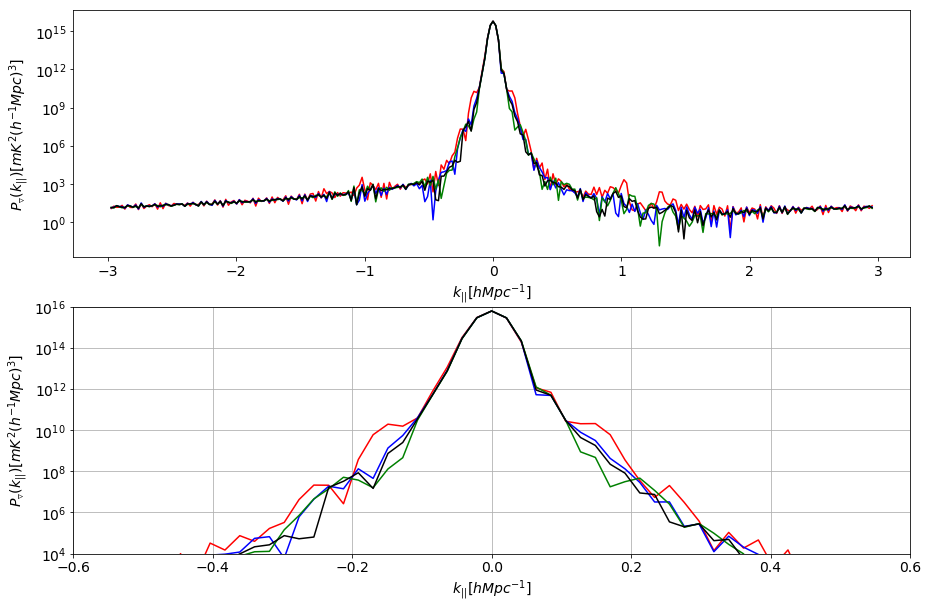

In [161]:
plt.figure(figsize=(15,10))
k_par,Power_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_0h.ms",triads)
k_par2,Power2_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_0h.ms",triads_edge)
k_par3,Power3_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_0h.ms",triads_center_edge)
ave=(Power2_0h+Power3_0h)/2
plt.subplot(2, 1, 1)
plt.semilogy(k_par,np.abs(Power_0h),'r',label='${E_{H}E_{H}E_{H}}$')
plt.semilogy(k_par2,np.abs(Power2_0h),'b',label='${E_{22}E_{22}E_{22}}$')
plt.semilogy(k_par3,np.abs(Power3_0h),'g',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par3,np.abs(ave),'k',label='${E_{26}E_{06}E_{22}}$')
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")

plt.subplot(2, 1, 2)
plt.semilogy(k_par,np.abs(Power_0h),'r',label='${E_{H}E_{H}E_{H}}$')
plt.semilogy(k_par2,np.abs(Power2_0h),'b',label='${E_{22}E_{22}E_{22}}$')
plt.semilogy(k_par3,np.abs(Power3_0h),'g',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par3,np.abs(ave),'k',label='${E_{26}E_{06}E_{22}}$')
# plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([1e4,1e16])
plt.xlim([-0.6,0.6])
plt.grid()

## Port 22

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_field_0h_Fornax.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_field_0h_GLEAM.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_field_0h_diffuse_emission.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_field_0h_Fornax.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files

Text(0,0.5,'$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$')

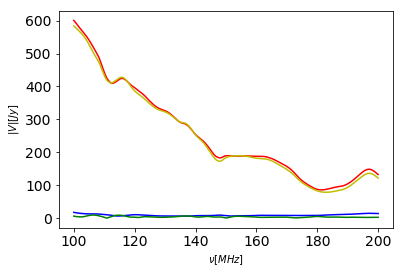

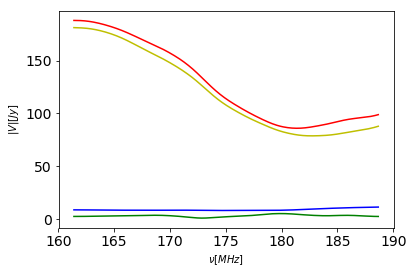

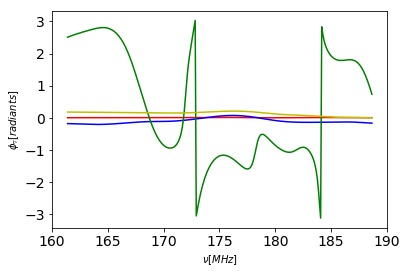

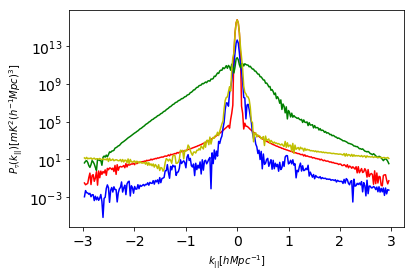

In [82]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad_EEC=[0,1,4]
triad_ECC=[2,4,6]
triad_CCC=[3,5,7]

c1,b1=closure_phase(path_to_GLEAM+'mutual_beam_field_0h_Fornax.ms',triad_EEC)
c2,b2=closure_phase(path_to_GLEAM+'mutual_beam_field_0h_GLEAM.ms',triad_EEC)
c3,b3=closure_phase(path_to_GLEAM+'mutual_beam_field_0h_diffuse_emission.ms',triad_EEC)
c4,b4=closure_phase(path_to_GLEAM+'mutual_beam_full_0h.ms',triad_EEC)
freq=np.linspace(100,200,1024)

plt.plot(freq,b1[0,:],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq,b2[0,:],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq,b3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,b4[0,:],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$|V| [Jy]$")

plt.figure()
plt.plot(freq[628:628+280],b1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],b2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],b3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],b4[0,:][628:628+280],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$|V| [Jy]$")

plt.figure()
plt.plot(freq[628:628+280],c1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],c2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],c3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],c4[0,:][628:628+280],'y',label='$\\triangledown_{CCC}$')

plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")


k_par,Power_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_field_0h_Fornax.ms",triad_CCC)
k_par2,Power2_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_field_0h_GLEAM.ms",triad_CCC)
k_par3,Power3_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_field_0h_diffuse_emission.ms",triad_CCC)
k_par4,Power4_0h=Power_Spectrum_Jy_2(path_to_GLEAM+'mutual_beam_full_0h.ms',triad_CCC)

plt.figure()
plt.semilogy(k_par,Power_0h,'r',label='Fornax')
plt.semilogy(k_par2,Power2_0h,'b',label='GLEAM')
plt.semilogy(k_par3,Power3_0h,'g',label='Diffuse emission')
plt.semilogy(k_par4,Power4_0h,'y',label='Full')

# plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_field_05h_Fornax.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_field_05h_GLEAM.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_field_05h_diffuse_emission.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_full_05h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_field_05h_Fornax.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEA

Text(0,0.5,'$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$')

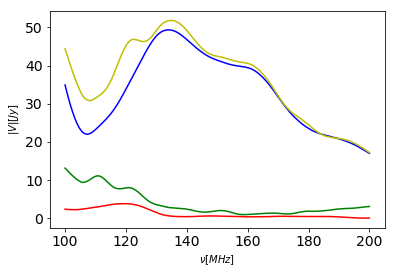

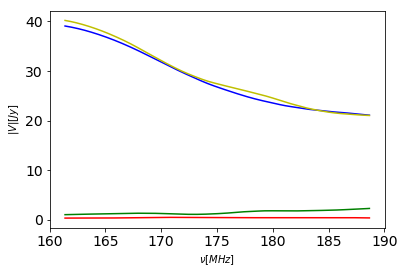

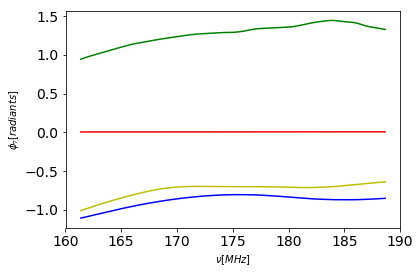

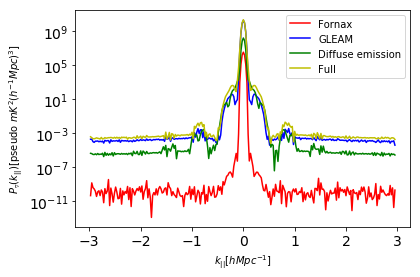

In [54]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad_EEC=[0,1,4]
triad_ECC=[2,4,6]
triad_CCC=[3,5,7]

c1,b1=closure_phase(path_to_GLEAM+'HERA_beam_field_05h_Fornax.ms',triad_CCC)
c2,b2=closure_phase(path_to_GLEAM+'HERA_beam_field_05h_GLEAM.ms',triad_CCC)
c3,b3=closure_phase(path_to_GLEAM+'HERA_beam_field_05h_diffuse_emission.ms',triad_CCC)
c4,b4=closure_phase(path_to_GLEAM+'HERA_beam_full_05h.ms',triad_CCC)
freq=np.linspace(100,200,1024)

plt.plot(freq,b1[0,:],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq,b2[0,:],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq,b3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,b4[0,:],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$|V| [Jy]$")

plt.figure()
plt.plot(freq[628:628+280],b1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],b2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],b3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],b4[0,:][628:628+280],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$|V| [Jy]$")


plt.figure()
plt.plot(freq[628:628+280],c1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],c2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],c3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],c4[0,:][628:628+280],'y',label='$\\triangledown_{CCC}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")


k_par,Power_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"HERA_beam_field_05h_Fornax.ms",triad_CCC)
k_par2,Power2_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"HERA_beam_field_05h_GLEAM.ms",triad_CCC)
k_par3,Power3_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"HERA_beam_field_05h_diffuse_emission.ms",triad_CCC)
k_par4,Power4_0h=Power_Spectrum_Jy_2(path_to_GLEAM+'HERA_beam_full_05h.ms',triad_CCC)

plt.figure()
plt.semilogy(k_par,Power_0h,'r',label='Fornax')
plt.semilogy(k_par2,Power2_0h,'b',label='GLEAM')
plt.semilogy(k_par3,Power3_0h,'g',label='Diffuse emission')
plt.semilogy(k_par4,Power4_0h,'y',label='Full')

plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_field_05h_Fornax.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_field_05h_GLEAM.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_field_05h_diffuse_emission.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_05h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_field_05h_Fornax.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_

Text(0,0.5,'$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$')

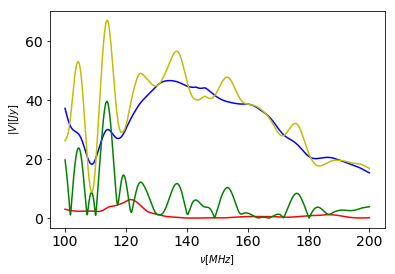

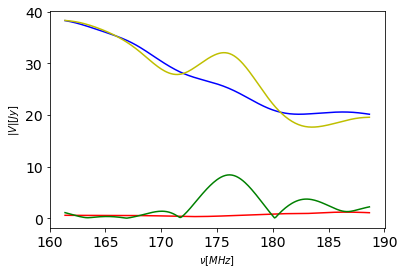

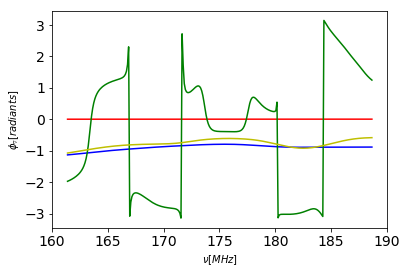

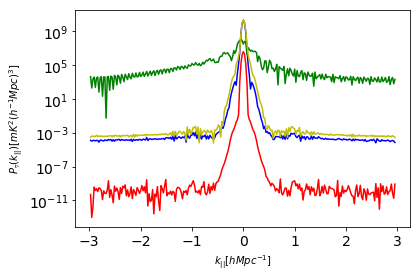

In [55]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad_EEC=[0,1,4]
triad_ECC=[2,4,6]
triad_CCC=[3,5,7]

c1,b1=closure_phase(path_to_GLEAM+'mutual_beam_field_05h_Fornax.ms',triad_CCC)
c2,b2=closure_phase(path_to_GLEAM+'mutual_beam_field_05h_GLEAM.ms',triad_CCC)
c3,b3=closure_phase(path_to_GLEAM+'mutual_beam_field_05h_diffuse_emission.ms',triad_CCC)
c4,b4=closure_phase(path_to_GLEAM+'mutual_beam_full_05h.ms',triad_CCC)
freq=np.linspace(100,200,1024)

plt.plot(freq,b1[0,:],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq,b2[0,:],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq,b3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,b4[0,:],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$|V| [Jy]$")

plt.figure()
plt.plot(freq[628:628+280],b1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],b2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],b3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],b4[0,:][628:628+280],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$|V| [Jy]$")

plt.figure()
plt.plot(freq[628:628+280],c1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],c2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],c3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],c4[0,:][628:628+280],'y',label='$\\triangledown_{CCC}$')

plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")


k_par,Power_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_field_05h_Fornax.ms",triad_CCC)
k_par2,Power2_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_field_05h_GLEAM.ms",triad_CCC)
k_par3,Power3_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_field_05h_diffuse_emission.ms",triad_CCC)
k_par4,Power4_0h=Power_Spectrum_Jy_2(path_to_GLEAM+'mutual_beam_full_05h.ms',triad_CCC)

plt.figure()
plt.semilogy(k_par,Power_0h,'r',label='Fornax')
plt.semilogy(k_par2,Power2_0h,'b',label='GLEAM')
plt.semilogy(k_par3,Power3_0h,'g',label='Diffuse emission')
plt.semilogy(k_par4,Power4_0h,'y',label='Full')

# plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_field_1h_Fornax.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_field_1h_GLEAM.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_field_1h_diffuse_emission.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_full_1h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_field_1h_Fornax.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_sim

Text(0,0.5,'$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$')

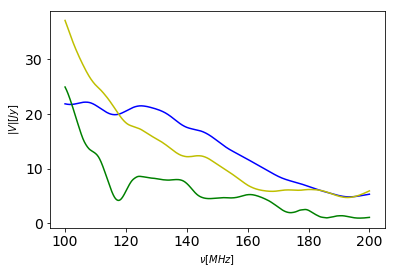

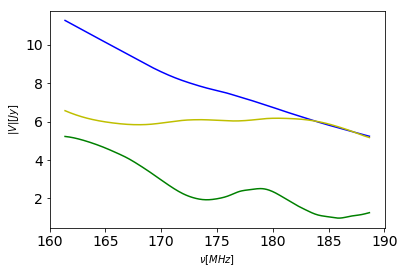

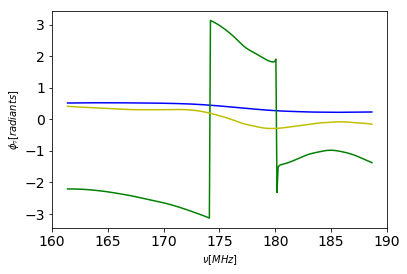

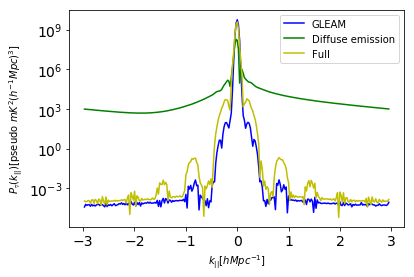

In [56]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad_EEC=[0,1,4]
triad_ECC=[2,4,6]
triad_CCC=[3,5,7]

c1,b1=closure_phase(path_to_GLEAM+'HERA_beam_field_1h_Fornax.ms',triad_CCC)
c2,b2=closure_phase(path_to_GLEAM+'HERA_beam_field_1h_GLEAM.ms',triad_CCC)
c3,b3=closure_phase(path_to_GLEAM+'HERA_beam_field_1h_diffuse_emission.ms',triad_CCC)
c4,b4=closure_phase(path_to_GLEAM+'HERA_beam_full_1h.ms',triad_CCC)
freq=np.linspace(100,200,1024)

# plt.plot(freq,b1[0,:],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq,b2[0,:],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq,b3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,b4[0,:],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$|V| [Jy]$")

plt.figure()
# plt.plot(freq[628:628+280],b1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],b2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],b3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],b4[0,:][628:628+280],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$|V| [Jy]$")

plt.figure()
# plt.plot(freq[628:628+280],c1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],c2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],c3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],c4[0,:][628:628+280],'y',label='$\\triangledown_{CCC}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")



k_par,Power_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"HERA_beam_field_1h_Fornax.ms",triad_CCC)
k_par2,Power2_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"HERA_beam_field_1h_GLEAM.ms",triad_CCC)
k_par3,Power3_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"HERA_beam_field_1h_diffuse_emission.ms",triad_CCC)
k_par4,Power4_0h=Power_Spectrum_Jy_2(path_to_GLEAM+'HERA_beam_full_1h.ms',triad_CCC)

plt.figure()
# plt.semilogy(k_par,Power_0h,'r',label='Fornax')
plt.semilogy(k_par2,Power2_0h,'b',label='GLEAM')
plt.semilogy(k_par3,Power3_0h,'g',label='Diffuse emission')
plt.semilogy(k_par4,Power4_0h,'y',label='Full')

plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_field_1h_GLEAM.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_field_1h_diffuse_emission.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_1h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_field_1h_GLEAM.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_field_1h_GLEAM.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/G

Text(0,0.5,'$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$')

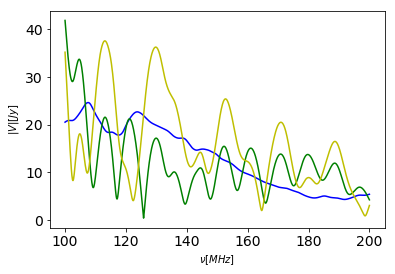

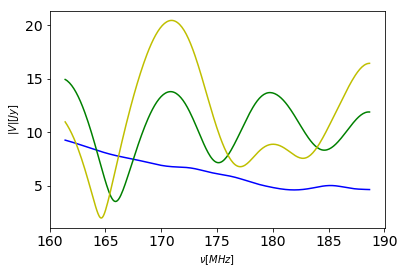

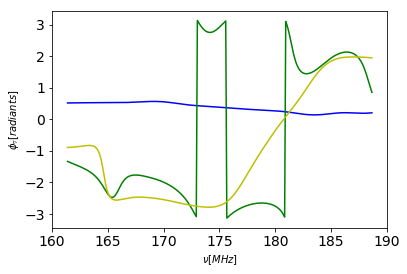

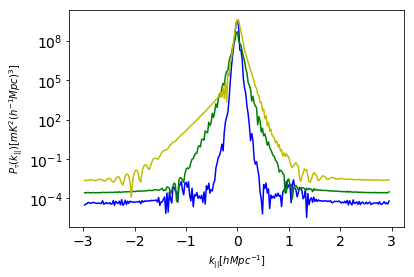

In [57]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad_EEC=[0,1,4]
triad_ECC=[2,4,6]
triad_CCC=[3,5,7]

# c1,b1=closure_phase(path_to_GLEAM+'mutual_beam_field_1h_Fornax.ms',triad_CCC)
c2,b2=closure_phase(path_to_GLEAM+'mutual_beam_field_1h_GLEAM.ms',triad_EEC)
c3,b3=closure_phase(path_to_GLEAM+'mutual_beam_field_1h_diffuse_emission.ms',triad_EEC)
c4,b4=closure_phase(path_to_GLEAM+'mutual_beam_full_1h.ms',triad_EEC)
freq=np.linspace(100,200,1024)

# plt.plot(freq,b1[0,:],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq,b2[0,:],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq,b3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,b4[0,:],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$|V| [Jy]$")

plt.figure()
# plt.plot(freq[628:628+280],b1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],b2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],b3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],b4[0,:][628:628+280],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$|V| [Jy]$")

plt.figure()
# plt.plot(freq[628:628+280],c1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],c2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],c3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],c4[0,:][628:628+280],'y',label='$\\triangledown_{CCC}$')

plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")


# k_par,Power_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_field_1h_Fornax.ms",triad_CCC)
k_par2,Power2_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_field_1h_GLEAM.ms",triad_CCC)
k_par3,Power3_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_field_1h_diffuse_emission.ms",triad_CCC)
k_par4,Power4_0h=Power_Spectrum_Jy_2(path_to_GLEAM+'mutual_beam_full_1h.ms',triad_CCC)

plt.figure()
# plt.semilogy(k_par,Power_0h,'r',label='Fornax')
plt.semilogy(k_par2,Power2_0h,'b',label='GLEAM')
plt.semilogy(k_par3,Power3_0h,'g',label='Diffuse emission')
plt.semilogy(k_par4,Power4_0h,'y',label='Full')

# plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_full_05h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_full_1h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam

Text(0,0.5,'$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$')

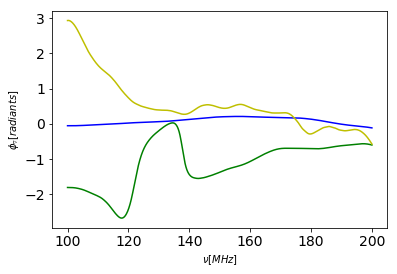

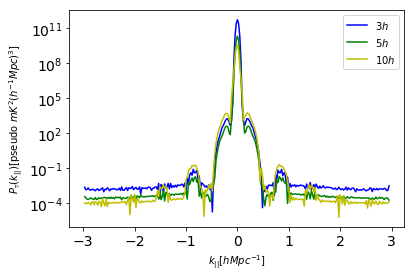

In [58]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad_EEC=[0,1,4]
triad_ECC=[2,4,6]
triad_CCC=[3,5,7]


c2,b2=closure_phase(path_to_GLEAM+'HERA_beam_full_0h.ms',triad_CCC)
c3,b3=closure_phase(path_to_GLEAM+'HERA_beam_full_05h.ms',triad_CCC)
c4,b4=closure_phase(path_to_GLEAM+'HERA_beam_full_1h.ms',triad_CCC)
freq=np.linspace(100,200,1024)

plt.plot(freq,c2[0,:],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq,c3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,c4[0,:],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

k_par2,Power2_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"HERA_beam_full_0h.ms",triad_CCC)
k_par3,Power3_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"HERA_beam_full_05h.ms",triad_CCC)
k_par4,Power4_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"HERA_beam_full_1h.ms",triad_CCC)

plt.figure()
plt.semilogy(k_par2,Power2_0h,'b',label='$3h$')
plt.semilogy(k_par3,Power3_0h,'g',label='$5h$')
plt.semilogy(k_par4,Power4_0h,'y',label='$10h$')

plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")


Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_05h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_1h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption

Text(0,0.5,'$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$')

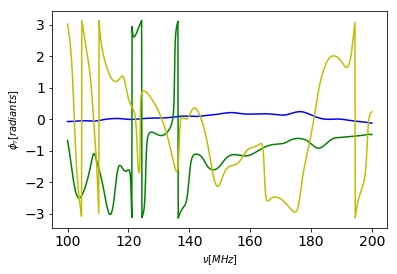

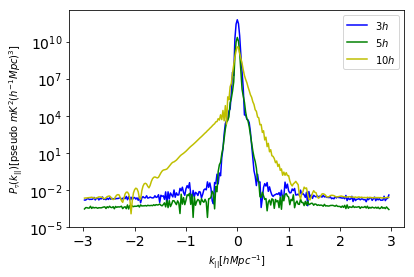

In [59]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad_EEC=[0,1,4]
triad_ECC=[2,4,6]
triad_CCC=[3,5,7]


c2,b2=closure_phase(path_to_GLEAM+'mutual_beam_full_0h.ms',triad_CCC)
c3,b3=closure_phase(path_to_GLEAM+'mutual_beam_full_05h.ms',triad_CCC)
c4,b4=closure_phase(path_to_GLEAM+'mutual_beam_full_1h.ms',triad_CCC)
freq=np.linspace(100,200,1024)

plt.plot(freq,c2[0,:],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq,c3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,c4[0,:],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

k_par2,Power2_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_0h.ms",triad_CCC)
k_par3,Power3_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_05h.ms",triad_CCC)
k_par4,Power4_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_1h.ms",triad_CCC)

plt.figure()
plt.semilogy(k_par2,Power2_0h,'b',label='$3h$')
plt.semilogy(k_par3,Power3_0h,'g',label='$5h$')
plt.semilogy(k_par4,Power4_0h,'y',label='$10h$')

plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_0h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_0h.ms: 24 columns, 28 rows


Text(0,0.5,'$\\phi_{\\triangledown}[radiants]$')

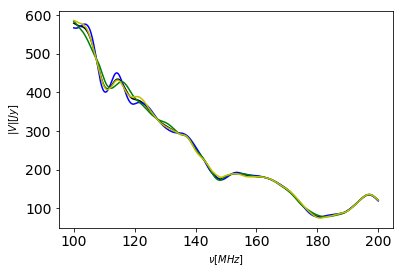

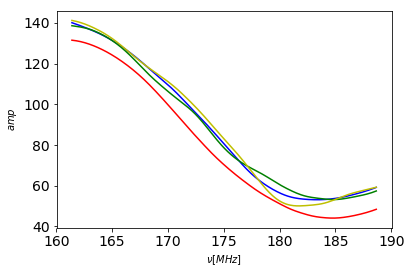

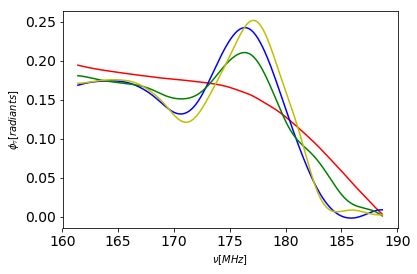

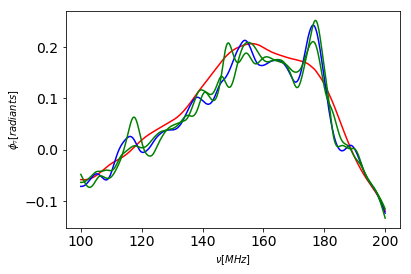

In [11]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad_EEC=[0,1,4]
triad_ECC=[2,4,6]
triad_CCC=[3,5,7]

c1,b1=closure_phase(path_to_GLEAM+'HERA_beam_full_0h.ms',triad_CCC)
c2,b2=closure_phase(path_to_GLEAM+'mutual_beam_full_0h.ms',triad_CCC)
c3,b3=closure_phase(path_to_GLEAM+'mutual_beam_full_0h.ms',triad_EEC)
c4,b4=closure_phase(path_to_GLEAM+'mutual_beam_full_0h.ms',triad_ECC)
freq=np.linspace(100,200,1024)

plt.plot(freq,np.abs((b2[0,:]+b3[0,:]+b4[0,:])/3),'k',label='${E_{H}E_{H}}$')
plt.plot(freq,np.abs(b2[0,:]),'b',label='${E_{06}E_{26}}$')
plt.plot(freq,np.abs(b3[0,:]),'g',label='${E_{26}E_{22}}$')
plt.plot(freq,np.abs(b4[0,:]),'y',label='${E_{22}E_{22}}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$|V|[Jy]$")
# plt.legend()

plt.figure()
plt.plot(freq[628:628+280],b1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],b2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],b3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],b4[0,:][628:628+280],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$amp$")

plt.figure()
plt.plot(freq[628:628+280],c1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],c2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],c3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],c4[0,:][628:628+280],'y',label='$\\triangledown_{CCC}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")
plt.figure()    
plt.plot(freq,c1[0,:],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq,c2[0,:],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq,c3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,c4[0,:],'g',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

# k_par,Power_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"HERA_beam_full_0h.ms",triad_CCC)
# k_par2,Power2_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_0h.ms",triad_CCC)
# k_par3,Power3_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_0h.ms",triad_EEC)
# k_par4,Power4_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_0h.ms",triad_ECC)

# plt.figure()

# plt.figure()
# plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
# plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
# plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
# plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
# # plt.legend()
# plt.xlabel("$k_{||}[h Mpc^{-1}]$")
# plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")
# plt.ylim([1e4,1e16])
# plt.xlim([-1,1])


# plt.subplot(2, 1, 1)
# plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
# plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
# plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
# plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
# plt.xlabel("$k_{||}[h Mpc^{-1}]$")
# plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")



# plt.subplot(2, 1, 2)
# plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
# plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
# plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
# plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
# # plt.legend()
# plt.xlabel("$k_{||}[h Mpc^{-1}]$")
# plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
# plt.ylim([1e4,1e16])
# plt.xlim([-0.6,0.6])
# plt.grid()


In [12]:
# k_par,Power_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"HERA_beam_full_0h.ms",triad_CCC)
# k_par2,Power2_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_0h.ms",triad_CCC)
# k_par3,Power3_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_0h.ms",triad_EEC)
# k_par4,Power4_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_0h.ms",triad_ECC)

# plt.figure()

# plt.figure()
# plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
# plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
# plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
# plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
# # plt.legend()
# plt.xlabel("$k_{||}[h Mpc^{-1}]$")
# plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")
# plt.ylim([1e4,1e16])
# plt.xlim([-1,1])


average deviation from beam without mutual coupling is 0.6163927
average deviation from beam triads 0.4627437


Text(0,0.5,'$\\phi_{\\triangledown}[radiants]$')

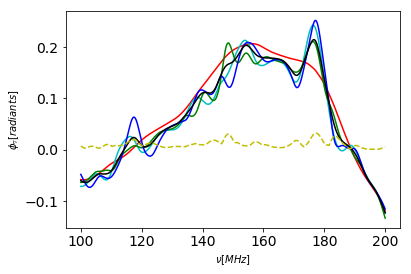

<Figure size 432x288 with 0 Axes>

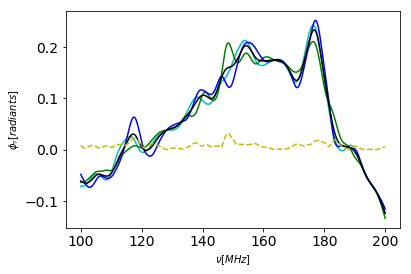

In [13]:

av_d1=(c1[0,:]+c2[0,:]+c3[0,:]+c4[0,:])/4.0
d0=np.abs(c1[0,:]-av_d1)
d1=np.abs(c2[0,:]-av_d1)
d2=np.abs(c3[0,:]-av_d1)
d3=np.abs(c4[0,:]-av_d1)
av_div=(d0+d1+d2+d3)/4

print("average deviation from beam without mutual coupling is "+str(np.rad2deg(np.mean(np.abs(av_div)))))

plt.figure()
plt.plot(freq,c1[0,:],'r',label='$\\triangledown_{ECC}$')
plt.plot(freq,c2[0,:],'c',label='$\\triangledown_{ECC}$')
plt.plot(freq,c3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,c4[0,:],'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,av_d1,'k',label='$\\triangledown_{CCC}$')
plt.plot(freq,av_div,'y--',label='$\\triangledown_{CCC}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

plt.figure()
av_d1=(c2[0,:]+c3[0,:]+c4[0,:])/3.0
d1=np.abs(c2[0,:]-av_d1)
d2=np.abs(c3[0,:]-av_d1)
d3=np.abs(c4[0,:]-av_d1)
av_div=(d1+d2+d3)/3


print("average deviation from beam triads "+str(np.rad2deg(np.mean(np.abs(av_div)))))
plt.figure()
plt.plot(freq,c2[0,:],'c',label='$\\triangledown_{CCC}$')
plt.plot(freq,c3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,c4[0,:],'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,av_d1,'k',label='$\\triangledown_{CCC}$')
plt.plot(freq,av_div,'y--',label='$\\triangledown_{CCC}$')

plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

average deviation from beam without mutual coupling is 1.7702776938676834
average deviation from beam triads 1.7702776938676834


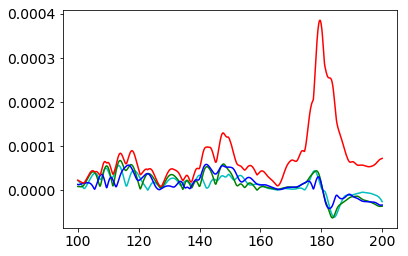

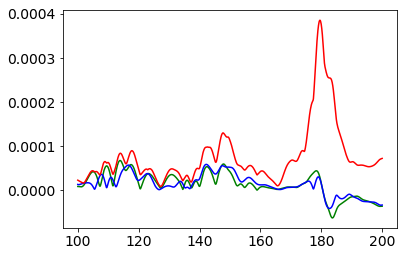

In [15]:
av_d1=(b2[0,:]+b3[0,:]+b4[0,:])/3
d1=np.abs(b2[0,:]-av_d1)/av_d1
d2=np.abs(b3[0,:]-av_d1)/av_d1
d3=np.abs(b4[0,:]-av_d1)/av_d1
av_div=(d1+d2+d3)/3

plt.figure()
plt.plot(freq,d1/av_d1,'c',label='$\\triangledown_{CCC}$')
plt.plot(freq,d2/av_d1,'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,d3/av_d1,'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,np.abs(av_div)/av_d1,'r',label='$\\triangledown_{CCC}$')
print("average deviation from beam without mutual coupling is "+str(100*np.mean(np.abs(av_div[628:628+280]))))



av_d2=(b2[0,:]+b3[0,:]+b4[0,:])/3
d1=np.abs(b2[0,:]-av_d2)/av_d2
d2=np.abs(b3[0,:]-av_d2)/av_d2
d3=np.abs(b4[0,:]-av_d2)/av_d2
av_div2=(d1+d2+d3)/3


print("average deviation from beam triads "+str(100*np.mean(np.abs(av_div2[628:628+280]))))
plt.figure()
plt.plot(freq,d2/av_d2,'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,d3/av_d2,'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,np.abs(av_div2)/av_d2,'r',label='$\\triangledown_{CCC}$')
# plt.plot(freq,av_d1,'k',label='$\\triangledown_{CCC}$')
# plt.plot(freq,av_div,'r--',label='$\\triangledown_{CCC}$')

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_full_05h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_05h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_05h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_05h.ms: 24 columns, 28 rows


Text(0,0.5,'$\\phi_{\\triangledown}[radiants]$')

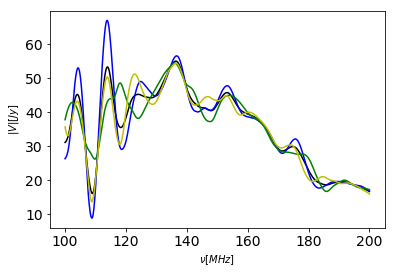

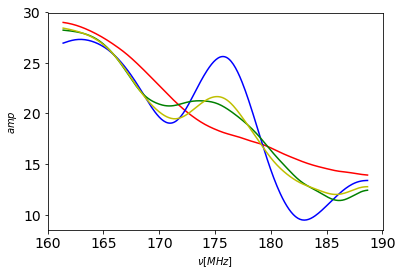

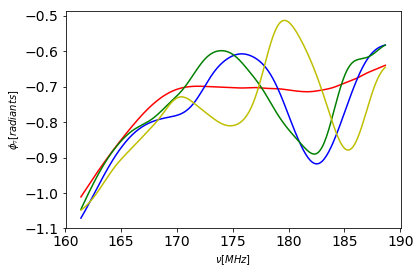

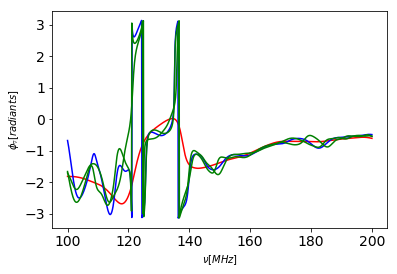

In [17]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad_EEC=[0,1,4]
triad_ECC=[2,4,6]
triad_CCC=[3,5,7]

c1,b1=closure_phase(path_to_GLEAM+'HERA_beam_full_05h.ms',triad_CCC)
c2,b2=closure_phase(path_to_GLEAM+'mutual_beam_full_05h.ms',triad_CCC)
c3,b3=closure_phase(path_to_GLEAM+'mutual_beam_full_05h.ms',triad_EEC)
c4,b4=closure_phase(path_to_GLEAM+'mutual_beam_full_05h.ms',triad_ECC)
freq=np.linspace(100,200,1024)

plt.plot(freq,np.abs((b2[0,:]+b3[0,:]+b4[0,:])/3),'k',label='${E_{H}E_{H}}$')
plt.plot(freq,np.abs(b2[0,:]),'b',label='${E_{06}E_{26}}$')
plt.plot(freq,np.abs(b3[0,:]),'g',label='${E_{26}E_{22}}$')
plt.plot(freq,np.abs(b4[0,:]),'y',label='${E_{22}E_{22}}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$|V|[Jy]$")
# plt.legend()

plt.figure()
plt.plot(freq[628:628+280],b1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],b2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],b3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],b4[0,:][628:628+280],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$amp$")

plt.figure()
plt.plot(freq[628:628+280],c1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],c2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],c3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],c4[0,:][628:628+280],'y',label='$\\triangledown_{CCC}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")
plt.figure()    
plt.plot(freq,c1[0,:],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq,c2[0,:],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq,c3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,c4[0,:],'g',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")


# k_par,Power_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"HERA_beam_full_05h.ms",triad_CCC)
# k_par2,Power2_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_05h.ms",triad_CCC)
# k_par3,Power3_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_05h.ms",triad_EEC)
# k_par4,Power4_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_05h.ms",triad_ECC)

# plt.subplot(2, 1, 1)
# plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
# plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
# plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
# plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
# plt.xlabel("$k_{||}[h Mpc^{-1}]$")
# plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
# plt.ylim([1e-3,1e15])


# plt.subplot(2, 1, 2)
# plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
# plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
# plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
# plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
# # plt.legend()
# plt.xlabel("$k_{||}[h Mpc^{-1}]$")
# plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
# plt.ylim([1e3,1e15])
# plt.xlim([-0.5,0.5])
# plt.grid()

average deviation from beam without mutual coupling is 12.548392
average deviation from beam triads 8.156841


Text(0,0.5,'$\\phi_{\\triangledown}[radiants]$')

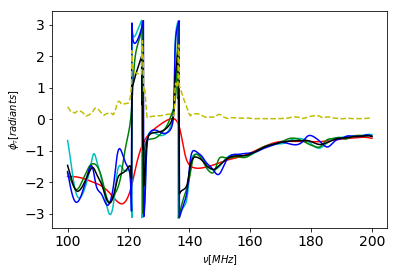

<Figure size 432x288 with 0 Axes>

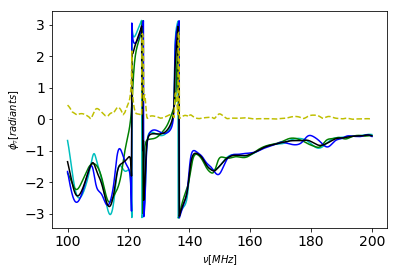

In [18]:
av_d1=(c1[0,:]+c2[0,:]+c3[0,:]+c4[0,:])/4.0
d0=np.abs(c1[0,:]-av_d1)
d1=np.abs(c2[0,:]-av_d1)
d2=np.abs(c3[0,:]-av_d1)
d3=np.abs(c4[0,:]-av_d1)
av_div=(d0+d1+d2+d3)/4

print("average deviation from beam without mutual coupling is "+str(np.rad2deg(np.mean(np.abs(av_div)))))

plt.figure()
plt.plot(freq,c1[0,:],'r',label='$\\triangledown_{ECC}$')
plt.plot(freq,c2[0,:],'c',label='$\\triangledown_{ECC}$')
plt.plot(freq,c3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,c4[0,:],'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,av_d1,'k',label='$\\triangledown_{CCC}$')
plt.plot(freq,av_div,'y--',label='$\\triangledown_{CCC}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

plt.figure()
av_d1=(c2[0,:]+c3[0,:]+c4[0,:])/3.0
d1=np.abs(c2[0,:]-av_d1)
d2=np.abs(c3[0,:]-av_d1)
d3=np.abs(c4[0,:]-av_d1)
av_div=(d1+d2+d3)/3


print("average deviation from beam triads "+str(np.rad2deg(np.mean(np.abs(av_div)))))
plt.figure()
plt.plot(freq,c2[0,:],'c',label='$\\triangledown_{CCC}$')
plt.plot(freq,c3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,c4[0,:],'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,av_d1,'k',label='$\\triangledown_{CCC}$')
plt.plot(freq,av_div,'y--',label='$\\triangledown_{CCC}$')

plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

average deviation from beam without mutual coupling is 10.7759989798069
average deviation from beam triads 5.989589542150497


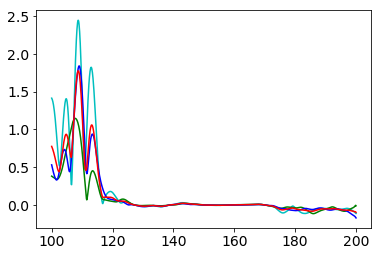

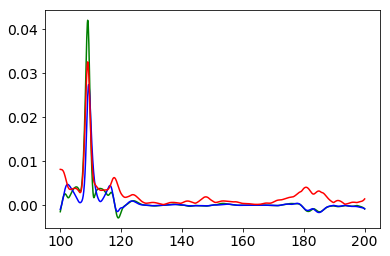

In [19]:
av_d1=b1[0,:]
d1=np.abs(b2[0,:]-av_d1)/av_d1
d2=np.abs(b3[0,:]-av_d1)/av_d1
d3=np.abs(b4[0,:]-av_d1)/av_d1
av_div=(d1+d2+d3)/3

plt.figure()
plt.plot(freq,(d1/av_d1)*100,'c',label='$\\triangledown_{CCC}$')
plt.plot(freq,(d2/av_d1)*100,'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,(d3/av_d1)*100,'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,(av_div/av_d1)*100,'r',label='$\\triangledown_{CCC}$')
print("average deviation from beam without mutual coupling is "+str(100*np.mean(np.abs(av_div[628:628+280]))))



av_d2=(b2[0,:]+b3[0,:]+b4[0,:])/3
d1=np.abs(b2[0,:]-av_d2)/av_d2
d2=np.abs(b3[0,:]-av_d2)/av_d2
d3=np.abs(b4[0,:]-av_d2)/av_d2
av_div2=(d1+d2+d3)/3


print("average deviation from beam triads "+str(100*np.mean(np.abs(av_div2[628:628+280]))))
plt.figure()
plt.plot(freq,d2/av_d2,'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,d3/av_d2,'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,np.abs(av_div2)/av_d2,'r',label='$\\triangledown_{CCC}$')
# plt.plot(freq,av_d1,'k',label='$\\triangledown_{CCC}$')
# plt.plot(freq,av_div,'r--',label='$\\triangledown_{CCC}$')

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_full_1h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_1h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_1h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/mutual_beam_full_1h.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/HERA_beam_full_1h.ms: 24 columns, 28 rows


TypeError: 'int' object has no attribute '__getitem__'

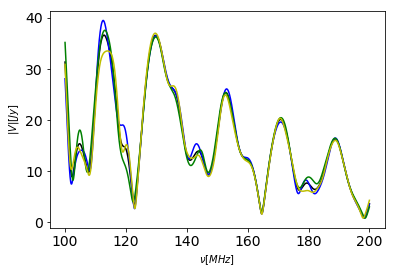

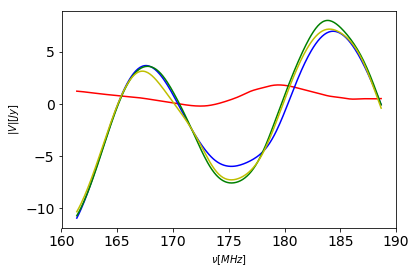

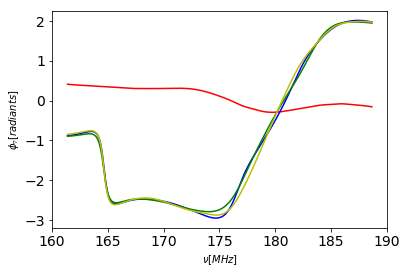

In [21]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad_EEC=[0,1,4]
triad_ECC=[2,4,6]
triad_CCC=[3,5,7]

c1,b1=closure_phase(path_to_GLEAM+'HERA_beam_full_1h.ms',triad_CCC)
c2,b2=closure_phase(path_to_GLEAM+'mutual_beam_full_1h.ms',triad_CCC)
c3,b3=closure_phase(path_to_GLEAM+'mutual_beam_full_1h.ms',triad_EEC)
c4,b4=closure_phase(path_to_GLEAM+'mutual_beam_full_1h.ms',triad_ECC)
freq=np.linspace(100,200,1024)

plt.plot(freq,np.abs((b2[0,:]+b3[0,:]+b4[0,:])/3),'k',label='${E_{H}E_{H}}$')
plt.plot(freq,np.abs(b2[0,:]),'b',label='${E_{06}E_{26}}$')
plt.plot(freq,np.abs(b3[0,:]),'g',label='${E_{26}E_{22}}$')
plt.plot(freq,np.abs(b4[0,:]),'y',label='${E_{22}E_{22}}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$|V|[Jy]$")
# plt.legend()

plt.figure()
plt.plot(freq[628:628+280],b1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],b2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],b3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],b4[0,:][628:628+280],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$|V| [Jy]$")

plt.figure()
plt.plot(freq[628:628+280],c1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],c2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],c3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],c4[0,:][628:628+280],'y',label='$\\triangledown_{CCC}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")


k_par,Power_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"HERA_beam_full_1h.ms",triad_CCC)
k_par2,Power2_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_1h.ms",triad_CCC)
k_par3,Power3_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_1h.ms",triad_EEC)
k_par4,Power4_0h=Power_Spectrum_Jy_2(path_to_GLEAM+"mutual_beam_full_1h.ms",triad_ECC)

plt.subplot(2, 1, 1)
plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")

plt.subplot(2, 1, 2)
plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
# plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([1e4,1e16])
plt.xlim([-0.6,0.6])
plt.grid()

average deviation from beam without mutual coupling is 32.02128
average deviation from beam triads 3.8427322


Text(0,0.5,'$\\phi_{\\triangledown}[radiants]$')

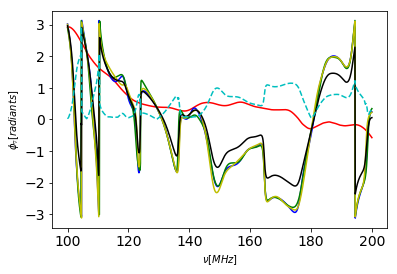

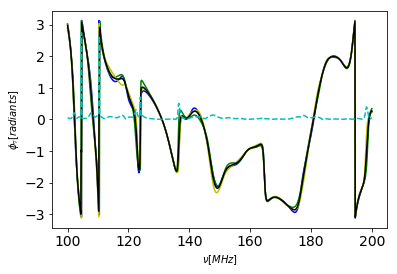

In [22]:


av_d1=(c1[0,:]+c2[0,:]+c3[0,:]+c4[0,:])/4.0
d0=np.abs(c1[0,:]-av_d1)
d1=np.abs(c2[0,:]-av_d1)
d2=np.abs(c3[0,:]-av_d1)
d3=np.abs(c4[0,:]-av_d1)
av_div=(d0+d1+d2+d3)/4

print("average deviation from beam without mutual coupling is "+str(np.rad2deg(np.mean(np.abs(av_div)))))

plt.figure()
plt.plot(freq,c1[0,:],'r',label='$\\triangledown_{ECC}$')
plt.plot(freq,c2[0,:],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq,c3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,c4[0,:],'y',label='$\\triangledown_{CCC}$')
plt.plot(freq,av_d1,'k',label='$\\triangledown_{CCC}$')
plt.plot(freq,av_div,'c--',label='$\\triangledown_{CCC}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")



av_d1=(c2[0,:]+c3[0,:]+c4[0,:])/3.0
d1=np.abs(c2[0,:]-av_d1)
d2=np.abs(c3[0,:]-av_d1)
d3=np.abs(c4[0,:]-av_d1)
av_div=(d1+d2+d3)/3


print("average deviation from beam triads "+str(np.rad2deg(np.mean(np.abs(av_div)))))
plt.figure()
plt.plot(freq,c2[0,:],'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,c3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,c4[0,:],'y',label='$\\triangledown_{CCC}$')
plt.plot(freq,av_d1,'k',label='$\\triangledown_{CCC}$')
plt.plot(freq,av_div,'c--',label='$\\triangledown_{CCC}$')

plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

average deviation from beam without mutual coupling is 164.11064863204956
average deviation from beam triads 6.71495720744133


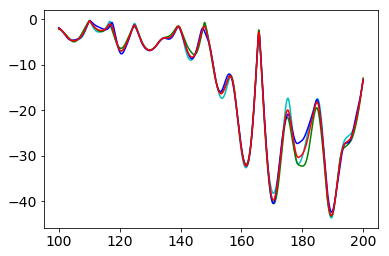

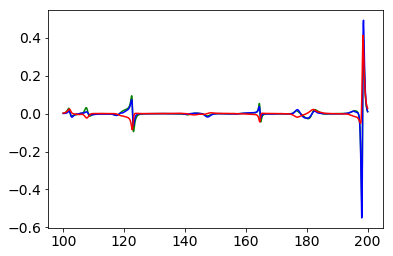

In [23]:

av_d1=b1[0,:]
d1=np.abs(b2[0,:]-av_d1)/av_d1
d2=np.abs(b3[0,:]-av_d1)/av_d1
d3=np.abs(b4[0,:]-av_d1)/av_d1
av_div=(d1+d2+d3)/3

plt.figure()
plt.plot(freq,(d1/av_d1)*100,'c',label='$\\triangledown_{CCC}$')
plt.plot(freq,(d2/av_d1)*100,'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,(d3/av_d1)*100,'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,(av_div/av_d1)*100,'r',label='$\\triangledown_{CCC}$')
print("average deviation from beam without mutual coupling is "+str(100*np.mean(np.abs(av_div[628:628+280]))))



av_d2=(b2[0,:]+b3[0,:]+b4[0,:])/3
d1=np.abs(b2[0,:]-av_d2)/av_d2
d2=np.abs(b3[0,:]-av_d2)/av_d2
d3=np.abs(b4[0,:]-av_d2)/av_d2
av_div2=(d1+d2+d3)/3


print("average deviation from beam triads "+str(100*np.mean(np.abs(av_div2[628:628+280]))))
plt.figure()
plt.plot(freq,d2/av_d2,'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,d3/av_d2,'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,np.abs(av_div2)/av_d2,'r',label='$\\triangledown_{CCC}$')
# plt.plot(freq,av_d1,'k',label='$\\triangledown_{CCC}$')
# plt.plot(freq,av_div,'r--',label='$\\triangledown_{CCC}$')

## Artifificial sky models

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_inner.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_outer.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_full.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_inner.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_inner.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_m

Text(0,0.5,'$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$')

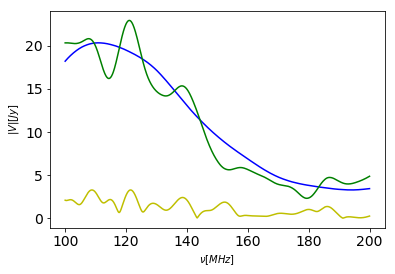

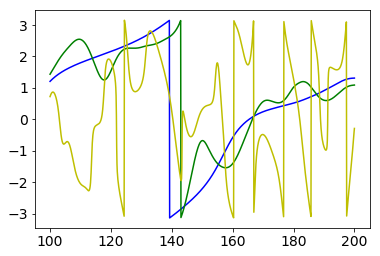

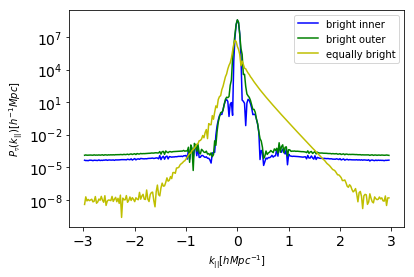

In [69]:
path_to_rand='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/'
triad_EEC=[0,1,4]
triad_ECC=[2,4,6]
triad_CCC=[3,5,7]


c2,b2=closure_phase(path_to_rand+'random_inner.ms',triad_CCC)
c3,b3=closure_phase(path_to_rand+'random_outer.ms',triad_CCC)
c4,b4=closure_phase(path_to_rand+'random_full.ms',triad_CCC)
freq=np.linspace(100,200,1024)

plt.figure()
plt.plot(freq,b2[0,:],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq,b3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,b4[0,:],'y',label='$\\triangledown_{HHH}$')
plt.ylabel("$\\|V| [Jy]$")
plt.xlabel("$\\nu [MHz]$")

plt.figure()
plt.plot(freq,c2[0,:],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq,c3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,c4[0,:],'y',label='$\\triangledown_{HHH}$')


k_par2,Power2_0h=Power_Spectrum_Jy_2(path_to_rand+"random_inner.ms",triad_CCC)
k_par3,Power3_0h=Power_Spectrum_Jy_2(path_to_rand+"random_outer.ms",triad_CCC)
k_par4,Power4_0h=Power_Spectrum_Jy_2(path_to_rand+"random_full.ms",triad_CCC)

plt.figure()
plt.semilogy(k_par2,Power2_0h,'b',label='bright inner')
plt.semilogy(k_par3,Power3_0h,'g',label='bright outer')
plt.semilogy(k_par4,Power4_0h,'y',label='equally bright')

plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_inner.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_mutual_inner.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_mutual_inner.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_mutual_inner.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_inner.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_

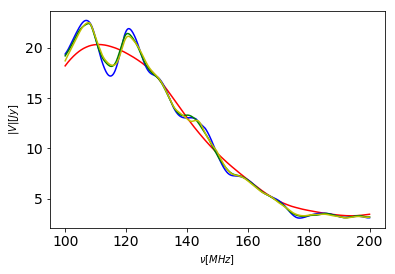

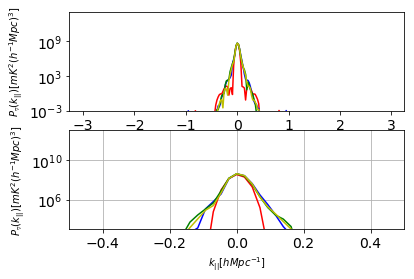

In [70]:
path_to_rand='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/'
triad_EEC=[0,1,4]
triad_ECC=[2,4,6]
triad_CCC=[3,5,7]

c1,b1=closure_phase(path_to_rand+'random_inner.ms',triad_CCC)
c2,b2=closure_phase(path_to_rand+'random_mutual_inner.ms',triad_CCC)
c3,b3=closure_phase(path_to_rand+'random_mutual_inner.ms',triad_ECC)
c4,b4=closure_phase(path_to_rand+'random_mutual_inner.ms',triad_EEC)
freq=np.linspace(100,200,1024)

plt.plot(freq,b1[0,:],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq,b2[0,:],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq,b3[0,:],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq,b4[0,:],'y',label='$\\triangledown_{HHH}$')
plt.ylabel("$\\|V| [Jy]$")
plt.xlabel("$\\nu [MHz]$")

plt.figure()
plt.plot(freq[628:628+280],c1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],c2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],c3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],c4[0,:][628:628+280],'g',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

k_par,Power_0h=Power_Spectrum_Jy_2(path_to_rand+"random_inner.ms",triad_CCC)
k_par2,Power2_0h=Power_Spectrum_Jy_2(path_to_rand+"random_mutual_inner.ms",triad_CCC)
k_par3,Power3_0h=Power_Spectrum_Jy_2(path_to_rand+"random_mutual_inner.ms",triad_ECC)
k_par4,Power4_0h=Power_Spectrum_Jy_2(path_to_rand+"random_mutual_inner.ms",triad_EEC)


# plt.figure()
# plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
# plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
# plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
# plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
# # plt.legend()
# plt.xlabel("$k_{||}[h Mpc^{-1}]$")
# plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")


# plt.figure()
# plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
# plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
# plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
# plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
# # plt.legend()
# plt.xlabel("$k_{||}[h Mpc^{-1}]$")
# plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")
# plt.ylim([1e1,1e13])
# plt.xlim([-1,1])


plt.subplot(2, 1, 1)
plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([1e-3,1e14])


plt.subplot(2, 1, 2)
plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
# plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([1e3,1e13])
plt.xlim([-0.5,0.5])
plt.grid()

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_outer.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_mutual_outer.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_mutual_outer.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_mutual_outer.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_outer.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_

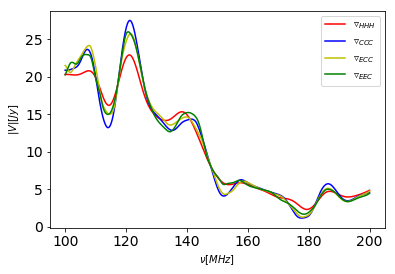

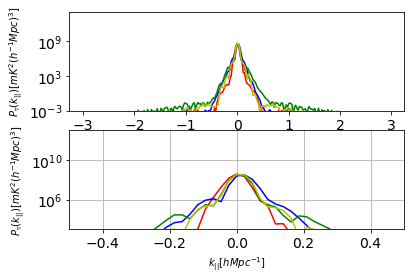

In [71]:
path_to_rand='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/'
triad_EEC=[0,1,4]
triad_ECC=[2,4,6]
triad_CCC=[3,5,7]

c1,b1=closure_phase(path_to_rand+'random_outer.ms',triad_CCC)
c2,b2=closure_phase(path_to_rand+'random_mutual_outer.ms',triad_CCC)
c3,b3=closure_phase(path_to_rand+'random_mutual_outer.ms',triad_ECC)
c4,b4=closure_phase(path_to_rand+'random_mutual_outer.ms',triad_EEC)
freq=np.linspace(100,200,1024)

plt.plot(freq,b1[0,:],'r',label='$\\triangledown_{HHH}$')
plt.plot(freq,b2[0,:],'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,b3[0,:],'y',label='$\\triangledown_{ECC}$')
plt.plot(freq,b4[0,:],'g',label='$\\triangledown_{EEC}$')
plt.ylabel("$\\|V| [Jy]$")
plt.xlabel("$\\nu [MHz]$")
plt.legend()

plt.figure()
plt.plot(freq[628:628+280],c1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],c2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],c3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],c4[0,:][628:628+280],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

k_par,Power_0h=Power_Spectrum_Jy_2(path_to_rand+"random_outer.ms",triad_CCC)
k_par2,Power2_0h=Power_Spectrum_Jy_2(path_to_rand+"random_mutual_outer.ms",triad_CCC)
k_par3,Power3_0h=Power_Spectrum_Jy_2(path_to_rand+"random_mutual_outer.ms",triad_ECC)
k_par4,Power4_0h=Power_Spectrum_Jy_2(path_to_rand+"random_mutual_outer.ms",triad_EEC)
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

# plt.figure()
# plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
# plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
# plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
# plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')

# # plt.legend()
# plt.xlabel("$k_{||}[h Mpc^{-1}]$")
# plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")
# plt.ylim([1e-3,1e14])

# plt.figure()
# plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
# plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
# plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
# plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
# # plt.legend()
# plt.xlabel("$k_{||}[h Mpc^{-1}]$")
# plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")
# plt.ylim([1e1,1e13])
# plt.xlim([-1,1])

plt.subplot(2, 1, 1)
plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([1e-3,1e14])


plt.subplot(2, 1, 2)
plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
# plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([1e3,1e13])
plt.xlim([-0.5,0.5])
plt.grid()

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_full.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_mutual_full.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_mutual_full.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_mutual_full.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_full.ms: 24 columns, 28 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files

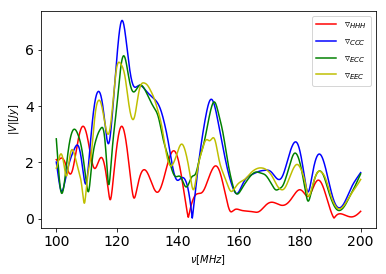

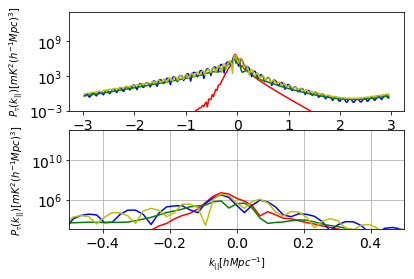

In [72]:
path_to_rand='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/'
triad_EEC=[0,1,4]
triad_ECC=[2,4,6]
triad_CCC=[3,5,7]

c1,b1=closure_phase(path_to_rand+'random_full.ms',triad_CCC)
c2,b2=closure_phase(path_to_rand+'random_mutual_full.ms',triad_CCC)
c3,b3=closure_phase(path_to_rand+'random_mutual_full.ms',triad_ECC)
c4,b4=closure_phase(path_to_rand+'random_mutual_full.ms',triad_EEC)


freq=np.linspace(100,200,1024)
plt.plot(freq,b1[0,:],'r',label='$\\triangledown_{HHH}$')
plt.plot(freq,b2[0,:],'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,b3[0,:],'g',label='$\\triangledown_{ECC}$')
plt.plot(freq,b4[0,:],'y',label='$\\triangledown_{EEC}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\|V| [Jy]$")
plt.legend()


plt.figure()
plt.plot(freq[628:628+280],c1[0,:][628:628+280],'r',label='$\\triangledown_{EEC}$')
plt.plot(freq[628:628+280],c2[0,:][628:628+280],'b',label='$\\triangledown_{ECC}$')
plt.plot(freq[628:628+280],c3[0,:][628:628+280],'g',label='$\\triangledown_{CCC}$')
plt.plot(freq[628:628+280],c4[0,:][628:628+280],'y',label='$\\triangledown_{HHH}$')
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")
# plt.legend()



k_par,Power_0h=Power_Spectrum_Jy_2(path_to_rand+"random_full.ms",triad_CCC)
k_par2,Power2_0h=Power_Spectrum_Jy_2(path_to_rand+"random_mutual_full.ms",triad_CCC)
k_par3,Power3_0h=Power_Spectrum_Jy_2(path_to_rand+"random_mutual_full.ms",triad_ECC)
k_par4,Power4_0h=Power_Spectrum_Jy_2(path_to_rand+"random_mutual_full.ms",triad_EEC)

# plt.figure()
# plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
# plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
# plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
# plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
# # plt.legend()
# plt.xlabel("$k_{||}[h Mpc^{-1}]$")
# plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")
# plt.ylim([1e-3,1e14])

# plt.figure()
# plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
# plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
# plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
# plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
# # plt.legend()
# plt.xlabel("$k_{||}[h Mpc^{-1}]$")
# plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")
# plt.ylim([1e1,1e13])
# plt.xlim([-1,1])

plt.subplot(2, 1, 1)
plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([1e-3,1e14])


plt.subplot(2, 1, 2)
plt.semilogy(k_par,Power_0h,'r',label='${E_{H}E_{H}E_{H}}$')
plt.semilogy(k_par2,Power2_0h,'b',label='${E_{22}E_{22}E_{22}}$')
plt.semilogy(k_par3,Power3_0h,'g',label='${E_{26}E_{06}E_{22}}$')
plt.semilogy(k_par4,Power4_0h,'y',label='${E_{06}E_{22}E_{22}}$')
# plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([1e3,1e13])
plt.xlim([-0.5,0.5])
plt.grid()

In [26]:
path_to_beam='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/6_source_models/'
triad=[0,1,12]
x=['3','4','5','6']
for k in range (len(x)):
    c1=closure_phase(path_to_beam+'model_'+x[k]+'.ms',triad)
    c2=closure_phase(path_to_beam+'beam_corrupted_hera_original_'+x[k]+'.ms',triad)
    freq=np.linspace(100,200,1024)
    plt.figure()
    plt.plot(freq,c1[0,:],'b',label='$\\triangledown_{AAA}$')
    plt.plot(freq,c2[0,:],'r',label='$\\triangledown_{LLL}$')
    plt.xlabel("$\\nu [MHz]$")
    plt.ylabel("$\\phi_{\\triangledown}[radiants]$")




Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/6_source_models/model_3.ms: 24 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/6_source_models/beam_corrupted_hera_original_3.ms: 25 columns, 82680 rows


TypeError: tuple indices must be integers, not tuple

<Figure size 432x288 with 0 Axes>

In [ ]:
t = np.linspace(100,200,1024)
data1 = closure_phase(path_to_beam+'model_outer3.ms',triad)[0,:]
data2 = closure_phase(path_to_beam+'beam_corrupted_hera_original_3_outer.ms',triad)[0,:]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('$\\nu [MHz]$')
ax1.set_ylabel('$\\phi_{\\triangledown}[radiants]$', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('$\\phi_{\\triangledown}[radiants]$', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_p

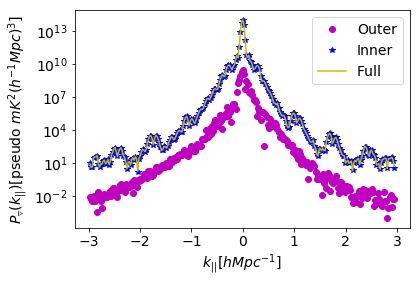

In [27]:
path_to_rand='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/'

triad=[0,1,12] 
triad3=[25,26,39]
triad2=[23,24,37]

k_par,Power=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_22_complex_outer.ms', triad)
k_par,Power2=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_22_complex.ms', triad)
k_par,Power3=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_22_complex_full.ms', triad)

plt.semilogy(k_par,Power,'mo',label='Outer')
plt.semilogy(k_par,Power2,'b*',label='Inner')
plt.semilogy(k_par,Power3,'y',label='Full')

plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")
plt.legend()

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_46_complex_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_46_complex_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_46_complex.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_46_complex.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_p

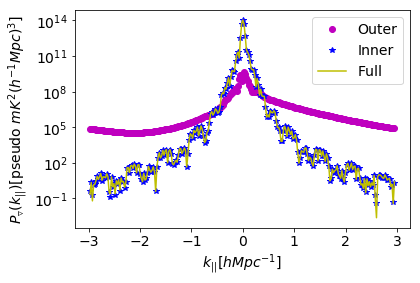

In [28]:
path_to_rand='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/'

triad=[0,1,12]
triad3=[25,26,39]
triad2=[23,24,37]
k_par,Power=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_46_complex_outer.ms', triad3)
k_par,Power2=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_46_complex.ms', triad3)
k_par,Power3=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_46_complex_full.ms', triad3)

plt.semilogy(k_par,Power,'mo',label='Outer')
plt.semilogy(k_par,Power2,'b*',label='Inner')
plt.semilogy(k_par,Power3,'y',label='Full')

plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")

plt.legend()

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_p

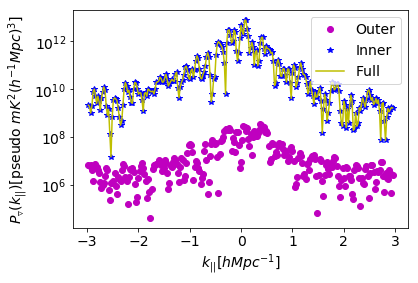

In [29]:
path_to_rand='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/'

triad=[0,1,12]
triad3=[25,26,39]
triad2=[23,24,37]
k_par,Power=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_22_complex_outer.ms',triad2)
k_par,Power2=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_22_complex.ms',triad2)
k_par,Power3=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_22_complex_full.ms',triad2)

plt.semilogy(k_par,Power,'mo',label='Outer')
plt.semilogy(k_par,Power2,'b*',label='Inner')
plt.semilogy(k_par,Power3,'y',label='Full')

plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")
plt.legend()

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_46_complex_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_46_complex_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_46_complex.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_46_complex.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_p

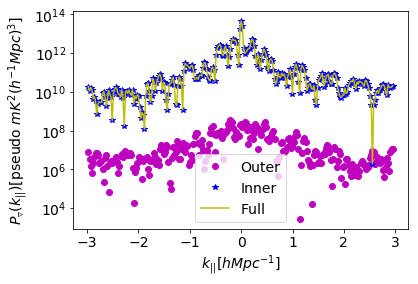

In [30]:
path_to_rand='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/'

triad=[0,1,12]
triad3=[25,26,39]
triad2=[23,24,37]
k_par,Power=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_46_complex_outer.ms', triad)
k_par,Power2=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_46_complex.ms', triad)
k_par,Power3=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_46_complex_full.ms', triad)

plt.semilogy(k_par,Power,'mo',label='Outer')
plt.semilogy(k_par,Power2,'b*',label='Inner')
plt.semilogy(k_par,Power3,'y',label='Full')

plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")
plt.legend()

NameError: name 'Power7' is not defined

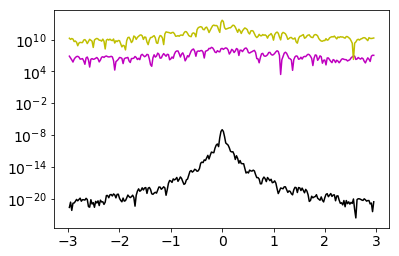

In [31]:
plt.semilogy(k_par,Power,'m',label='E_22_outer')
plt.semilogy(k_par,Power3,'y',label='E_22_inner')
plt.semilogy(k_par,Power5,'k',label='E_22_full')
plt.semilogy(k_par,Power7,'r',label='E_H_full')
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")
plt.legend()

In [ ]:
plt.semilogy(k_par,Power,'r',label='E_22_outer')
plt.semilogy(k_par,Power3,'y',label='E_22_inner')
plt.semilogy(k_par,Power5,'k',label='E_22_full')
plt.legend()
plt.figure()
plt.semilogy(k_par,Power2,'b',label='E_46_outer')
plt.semilogy(k_par,Power4,'g',label='E_46_inner')
plt.semilogy(k_par,Power6,'c',label='E_46_full')
plt.legend()

In [ ]:
triad=[0,1,12]
triad2=[1,2,13]
path_two_sky='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/'
k_par,Power=Power_Spectrum_Jy(path_two_sky+'rel_1000_flux.ms',triad)
k_par,Power2=Power_Spectrum_Jy(path_two_sky+'rel_100_flux.ms',triad)
k_par,Power3=Power_Spectrum_Jy(path_two_sky+'rel_10_flux.ms',triad)
k_par,Power4=Power_Spectrum_Jy(path_two_sky+'rel_1_flux.ms' ,triad)

plt.semilogy(k_par,Power,'m',label='rel_1000')
plt.semilogy(k_par,Power2,'b',label='rel_100')
plt.semilogy(k_par,Power3,'y',label='rel_10')
plt.semilogy(k_par,Power4,'g',label='rel_1')

plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo Jy Hz]")
plt.legend()

In [ ]:
triad=[0,1,12]
triad2=[1,2,13]
path_two_sky='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/'
k_par,Power=Power_Spectrum_Jy(path_two_sky+'rel_1000_flux_3.ms',triad)
k_par,Power2=Power_Spectrum_Jy(path_two_sky+'rel_100_flux_3.ms',triad)
k_par,Power3=Power_Spectrum_Jy(path_two_sky+'rel_10_flux_3.ms',triad)
k_par,Power4=Power_Spectrum_Jy(path_two_sky+'rel_1_flux_3.ms' ,triad)
k_par,Power5=Power_Spectrum_Jy(path_two_sky+'rel_10000_flux_3.ms',triad)
k_par,Power6=Power_Spectrum_Jy(path_two_sky+'rel_0_flux_3.ms',triad)
k_par,Power7=Power_Spectrum_Jy(path_two_sky+'rel_1000000_flux_3.ms',triad)

# plt.semilogy(k_par,Power,'m',label='flux=1mJy')
# plt.semilogy(k_par,Power2,'b',label='flux=10mJy')
# plt.semilogy(k_par,Power3,'y',label='flux=100mJy')
plt.semilogy(k_par,Power4,'g',label='flux=1000mJy')
# plt.semilogy(k_par,Power5,'c',label='flux=0.1mJy')
plt.semilogy(k_par,Power6,'k',label='flux=0mJy')
# plt.semilogy(k_par,Power7,'r',label='flux=0.01mJy')

plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo Jy Hz]")
plt.legend()

In [ ]:
plt.semilogy(k_par,Power,'m',label='flux=1mJy')
plt.semilogy(k_par,Power2,'b',label='flux=10mJy')
plt.semilogy(k_par,Power3,'y',label='flux=100mJy')
plt.semilogy(k_par,Power4,'g',label='flux=1000mJy')
plt.semilogy(k_par,Power5,'c',label='flux=0.1mJy')
plt.semilogy(k_par,Power6,'k',label='flux=0mJy')

plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")
plt.legend()

In [ ]:
c1=closure_phase(path_two_sky+'rel_1000_flux_3.ms',triad)
c2=closure_phase(path_two_sky+'rel_100_flux_3.ms',triad)
c3=closure_phase(path_two_sky+'rel_10_flux_3.ms',triad)
c4=closure_phase(path_two_sky+'rel_1_flux_3.ms',triad)
c5=closure_phase(path_two_sky+'rel_10000_flux_3.ms',triad)
c6=closure_phase(path_two_sky+'rel_0_flux_3.ms',triad)
c7=closure_phase(path_two_sky+'rel_1000000_flux_3.ms',triad)

freq=np.linspace(161,189,280)
plt.plot(freq,c1[0,628:908],'m',label='flux=1mJy')
plt.plot(freq,c2[0,628:908],'b',label='flux=10mJy')
plt.plot(freq,c3[0,628:908],'y',label='flux=100mJy')
plt.plot(freq,c4[0,628:908],'g',label='flux=1000mJy')
plt.plot(freq,c5[0,628:908],'c',label='flux=0.1mJy')
plt.plot(freq,c6[0,628:908],'k',label='flux=0mJy')


plt.legend()
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

## GLEAM 200mJy 

In [ ]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad=[0,1,2]
triad2=[3,4,5]
d1=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_0h_original_high_band_no_Fornax_field.ms',triad,d_band='High_band')
d2=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port22_high_band_no_Fornax_field.ms',triad,d_band='High_band')
d3=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port46_high_band_no_Fornax_field.ms',triad,d_band='High_band')
d4=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port46_high_band_no_Fornax_field.ms',triad2,d_band='High_band')
d5=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port22_high_band_no_Fornax_field.ms',triad2,d_band='High_band')

k_par,Power=Power_spectrum(d1[0],d1[1],"High_band")
k_par2,Power2=Power_spectrum(d2[0],d2[1],"High_band")
k_par3,Power3=Power_spectrum(d3[0],d3[1],"High_band")
k_par4,Power4=Power_spectrum(d4[0],d4[1],"High_band")
k_par5,Power5=Power_spectrum(d5[0],d5[1],"High_band")

plt.semilogy(k_par,Power,'r',label='E_H')
plt.semilogy(k_par2,Power2,'b',label='E_22')
plt.semilogy(k_par3,Power3,'g',label='E_22,2E_46')
plt.semilogy(k_par4,Power4,'y',label='E_46')
plt.semilogy(k_par5,Power5,'m',label='2E22,E_46')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})[h Mpc^{-1}]$")

In [ ]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad=[0,1,2]
triad2=[3,4,5]
d1=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_05h_original_high_band_no_Fornax_field.ms',triad,d_band='High_band')
d2=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port22_high_band_no_Fornax_field.ms',triad,d_band='High_band')
d3=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port46_high_band_no_Fornax_field.ms',triad,d_band='High_band')
d4=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port46_high_band_no_Fornax_field.ms',triad2,d_band='High_band')
d5=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port22_high_band_no_Fornax_field.ms',triad2,d_band='High_band')

k_par,Power=Power_spectrum(d1[0],d1[1],"High_band")
k_par2,Power2=Power_spectrum(d2[0],d2[1],"High_band")
k_par3,Power3=Power_spectrum(d3[0],d3[1],"High_band")
k_par4,Power4=Power_spectrum(d4[0],d4[1],"High_band")
k_par5,Power5=Power_spectrum(d5[0],d5[1],"High_band")

plt.semilogy(k_par,Power,'r',label='E_H')
plt.semilogy(k_par2,Power2,'b',label='E_22')
plt.semilogy(k_par3,Power3,'g',label='E_22,2E_46')
plt.semilogy(k_par4,Power4,'y',label='E_46')
plt.semilogy(k_par5,Power5,'m',label='2E22,E_46')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})[h Mpc^{-1}]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_original_high_band_no_Fornax_field.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_original_high_band_no_Fornax_field.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_port22_high_band_no_Fornax_field.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_port22_high_band_no_Fornax_field.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_port46_high_band_n

Text(0,0.5,'$P_{\\triangledown}(k_{||})[h Mpc^{-1}]$')

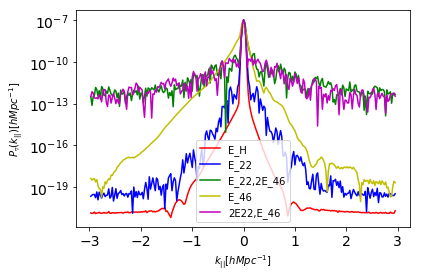

In [14]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad=[0,1,2]
triad2=[3,4,5]
d1=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_1h_original_high_band_no_Fornax_field.ms',triad,d_band='High_band')
d2=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port22_high_band_no_Fornax_field.ms',triad,d_band='High_band')
d3=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port46_high_band_no_Fornax_field.ms',triad,d_band='High_band')
d4=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port46_high_band_no_Fornax_field.ms',triad2,d_band='High_band')
d5=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port22_high_band_no_Fornax_field.ms',triad2,d_band='High_band')

k_par,Power=Power_spectrum(d1[0],d1[1],"High_band")
k_par2,Power2=Power_spectrum(d2[0],d2[1],"High_band")
k_par3,Power3=Power_spectrum(d3[0],d3[1],"High_band")
k_par4,Power4=Power_spectrum(d4[0],d4[1],"High_band")
k_par5,Power5=Power_spectrum(d5[0],d5[1],"High_band")

plt.semilogy(k_par,Power,'r',label='E_H')
plt.semilogy(k_par2,Power2,'b',label='E_22')
plt.semilogy(k_par3,Power3,'g',label='E_22,2E_46')
plt.semilogy(k_par4,Power4,'y',label='E_46')
plt.semilogy(k_par5,Power5,'m',label='2E22,E_46')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})[h Mpc^{-1}]$")

## Zernike Beams

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_rand_original_beam_full.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_30_low.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_30_high.ms: 25 columns, 82680 rows


Text(0,0.5,'$\\phi_{\\triangledown}[radiants]$')

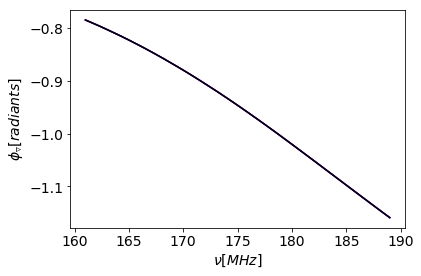

In [59]:
path_to_rand='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/'
triad=[0,1,12]
c1=closure_phase(path_to_rand+'30_rand_original_beam_full.ms',triad)
c2=closure_phase(path_to_rand+'random_30_low.ms',triad)
c3=closure_phase(path_to_rand+'random_30_high.ms',triad)

freq=np.linspace(161,189,280)
plt.plot(freq,c1[0,628:908],'r',label='$\\triangledown_{AAA}$')
plt.plot(freq,c2[0,628:908],'b',label='$\\triangledown_{LLL}$')
plt.plot(freq,c3[0,628:908],'k',label='$\\triangledown_{HHH}$')

#plt.legend()
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_30_high.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_30_high.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_30_low.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/random_30_low.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_rand_original_beam_full.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo

Text(0,0.5,'$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$')

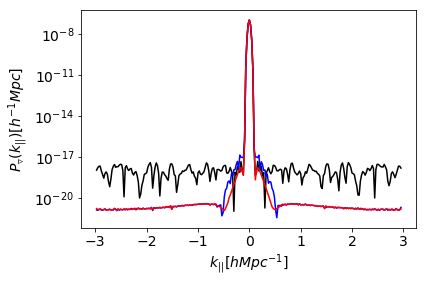

In [60]:

path_to_rand='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/'
triad=[0,1,12]
triad3=[40,41,55]
triad2=[23,24,37]
d1=Delay_finder2(path_to_rand+'random_30_high.ms',triad,d_band='High_band')
d2=Delay_finder2(path_to_rand+'random_30_low.ms',triad,d_band='High_band')
d3=Delay_finder2(path_to_rand+'30_rand_original_beam_full.ms',triad,d_band='High_band')


k_par,Power=Power_spectrum(d1[0],d1[1],"High_band")
k_par2,Power2=Power_spectrum(d2[0],d2[1],"High_band")
k_par3,Power3=Power_spectrum(d3[0],d3[1],"High_band")

plt.semilogy(k_par,Power,'k',label='$\\triangledown_{HHH}$')
plt.semilogy(k_par2,Power2,'b',label='$\\triangledown_{LLL}$')
plt.semilogy(k_par3,Power3,'r',label='$\\triangledown_{AAA}$')

#plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/outer_random_30_original_beam.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/outer_random_low.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/outer_random_high.ms: 25 columns, 82680 rows


Text(0,0.5,'$\\phi_{\\triangledown}[radiants]$')

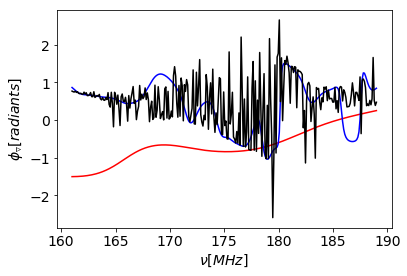

In [61]:
path_to_rand='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/'
triad=[0,1,12]
c1=closure_phase(path_to_rand+'outer_random_30_original_beam.ms',triad)
c2=closure_phase(path_to_rand+'outer_random_low.ms',triad)
c3=closure_phase(path_to_rand+'outer_random_high.ms',triad)

freq=np.linspace(161,189,280)
plt.plot(freq,c1[0,628:908],'r',label='$\\triangledown_{AAA}$')
plt.plot(freq,c2[0,628:908],'b',label='$\\triangledown_{LLL}$')
plt.plot(freq,c3[0,628:908],'k',label='$\\triangledown_{HHH}$')

#plt.legend()
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/outer_random_high.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/outer_random_high.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/outer_random_low.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/outer_random_low.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/outer_random_30_original_beam.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault

Text(0,0.5,'$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$')

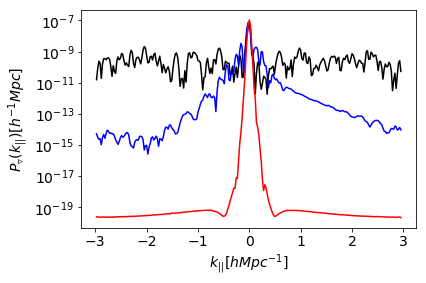

In [62]:
path_to_rand='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/'
triad=[0,1,12]
triad3=[40,41,55]
triad2=[23,24,37]
d1=Delay_finder2(path_to_rand+'outer_random_high.ms',triad,d_band='High_band')
d2=Delay_finder2(path_to_rand+'outer_random_low.ms',triad,d_band='High_band')
d3=Delay_finder2(path_to_rand+'outer_random_30_original_beam.ms',triad,d_band='High_band')


k_par,Power=Power_spectrum(d1[0],d1[1],"High_band")
k_par2,Power2=Power_spectrum(d2[0],d2[1],"High_band")
k_par3,Power3=Power_spectrum(d3[0],d3[1],"High_band")

plt.semilogy(k_par,Power,'k',label='$\\triangledown_{HHH}$')
plt.semilogy(k_par2,Power2,'b',label='$\\triangledown_{LLL}$')
plt.semilogy(k_par3,Power3,'r',label='$\\triangledown_{AAA}$')

#plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$")

## 30 artificial sky model 

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_rand_original_beam.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_rand_original_beam.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_46_complex.ms: 25 columns, 82680 rows


(0.001, 1000000000000000)

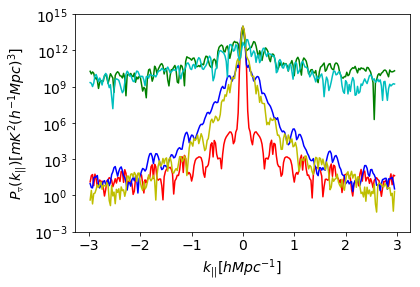

In [32]:
path_to_rand='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/'
triad=[0,1,12]
triad3=[25,26,39]
triad2=[23,24,37]


k_par,Power=Power_Spectrum_Jy(path_to_rand+'30_rand_original_beam.ms',triad)
k_par2,Power2=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_22_complex.ms',triad)
k_par3,Power3=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_46_complex.ms',triad)
k_par5,Power5=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_46_complex.ms',triad3)
k_par6,Power6=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_22_complex.ms',triad2)

plt.semilogy(k_par,Power,'r',label='$\\triangledown_{AAA}$')
plt.semilogy(k_par2,Power2,'b',label='$\\triangledown_{CCC}$')
plt.semilogy(k_par3,Power3,'g',label='$\\triangledown_{CEE}$')
plt.semilogy(k_par5,Power5,'y',label='$\\triangledown_{EEE}$')
plt.semilogy(k_par6,Power6,'c',label='$\\triangledown_{ECC}$')
#plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([10**-3,10**15])

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_rand_original_beam.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_46_complex.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_46_complex.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex.ms: 25 colum

Text(0,0.5,'$\\phi_{\\triangledown}[radiants]$')

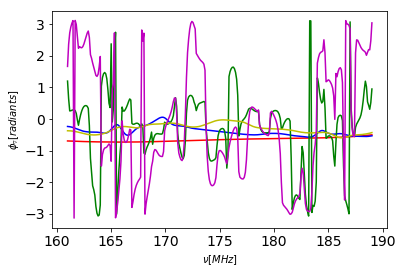

In [6]:
c1=closure_phase(path_to_rand+'30_rand_original_beam.ms',triad)
c2=closure_phase(path_to_rand+'30_artificial_mutual_port_22_complex.ms',triad)
c3=closure_phase(path_to_rand+'30_artificial_mutual_port_46_complex.ms',triad)
c4=closure_phase(path_to_rand+'30_artificial_mutual_port_46_complex.ms',triad3)
c5=closure_phase(path_to_rand+'30_artificial_mutual_port_22_complex.ms',triad2)

freq=np.linspace(161,189,280)
plt.plot(freq,c1[0,628:908],'r',label='$\\triangledown_{AAA}$')
plt.plot(freq,c2[0,628:908],'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,c3[0,628:908],'g',label='$\\triangledown_{CEE}$')
plt.plot(freq,c4[0,628:908],'y',label='$\\triangledown_{EEE}$')
plt.plot(freq,c5[0,628:908],'m',label='$\\triangledown_{ECC}$')
#plt.legend()
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_rand_original_beam_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_rand_original_beam_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_46_complex_out

(1e-05, 10000000000)

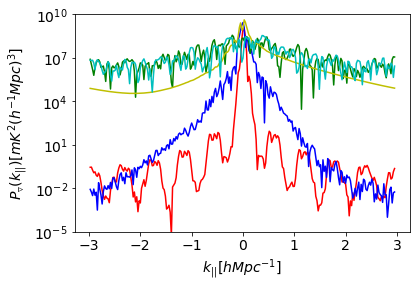

In [36]:
path_to_rand='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/'
triad=[0,1,12]
triad3=[25,26,39]
triad2=[23,24,37]


k_par,Power=Power_Spectrum_Jy(path_to_rand+'30_rand_original_beam_outer.ms',triad)
k_par2,Power2=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_22_complex_outer.ms',triad)
k_par3,Power3=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_46_complex_outer.ms',triad)
k_par5,Power5=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_46_complex_outer.ms',triad3)
k_par6,Power6=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_22_complex_outer.ms',triad2)

plt.semilogy(k_par,Power,'r',label='$\\triangledown_{AAA}$')
plt.semilogy(k_par2,Power2,'b',label='$\\triangledown_{CCC}$')
plt.semilogy(k_par3,Power3,'g',label='$\\triangledown_{CEE}$')
plt.semilogy(k_par5,Power5,'y',label='$\\triangledown_{EEE}$')
plt.semilogy(k_par6,Power6,'c',label='$\\triangledown_{ECC}$')
#plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([10**-5,10**10])

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_rand_original_beam_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_46_complex_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_46_complex_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port

Text(0,0.5,'$\\phi_{\\triangledown}[radiants]$')

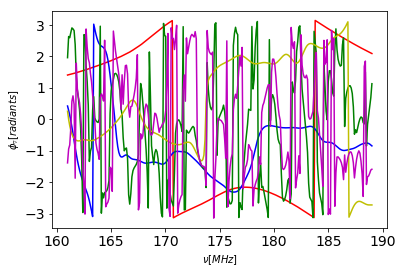

In [15]:
c1=closure_phase(path_to_rand+'30_rand_original_beam_outer.ms',triad)
c2=closure_phase(path_to_rand+'30_artificial_mutual_port_22_complex_outer.ms',triad)
c3=closure_phase(path_to_rand+'30_artificial_mutual_port_46_complex_outer.ms',triad)
c4=closure_phase(path_to_rand+'30_artificial_mutual_port_46_complex_outer.ms',triad3)
c5=closure_phase(path_to_rand+'30_artificial_mutual_port_22_complex_outer.ms',triad2)

freq=np.linspace(161,189,280)
plt.plot(freq,c1[0,628:908],'r',label='$\\triangledown_{AAA}$')
plt.plot(freq,c2[0,628:908],'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,c3[0,628:908],'g',label='$\\triangledown_{CEE}$')
plt.plot(freq,c4[0,628:908],'y',label='$\\triangledown_{EEE}$')
plt.plot(freq,c5[0,628:908],'m',label='$\\triangledown_{ECC}$')
#plt.legend()
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_rand_original_beam_full.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_rand_original_beam_full.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex_full.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex_full.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_46_complex_full.ms

(0.001, 1000000000000000)

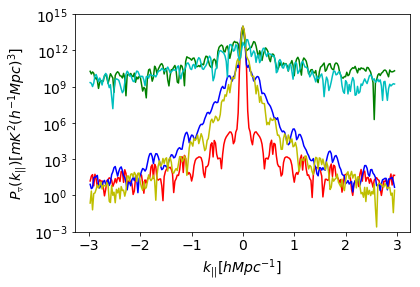

In [35]:
path_to_rand='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/'
triad=[0,1,12]
triad3=[25,26,39]
triad2=[23,24,37]


k_par,Power=Power_Spectrum_Jy(path_to_rand+'30_rand_original_beam_full.ms',triad)
k_par2,Power2=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_22_complex_full.ms',triad)
k_par3,Power3=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_46_complex_full.ms',triad)
k_par5,Power5=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_46_complex_full.ms',triad3)
k_par6,Power6=Power_Spectrum_Jy(path_to_rand+'30_artificial_mutual_port_22_complex_full.ms',triad2)

plt.semilogy(k_par,Power,'r',label='$\\triangledown_{AAA}$')
plt.semilogy(k_par2,Power2,'b',label='$\\triangledown_{CCC}$')
plt.semilogy(k_par3,Power3,'g',label='$\\triangledown_{CEE}$')
plt.semilogy(k_par5,Power5,'y',label='$\\triangledown_{EEE}$')
plt.semilogy(k_par6,Power6,'c',label='$\\triangledown_{ECC}$')
#plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([10**-3,10**15])

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_rand_original_beam_full.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex_full.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_46_complex_full.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_46_complex_full.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_

Text(0,0.5,'$\\phi_{\\triangledown}[radiants]$')

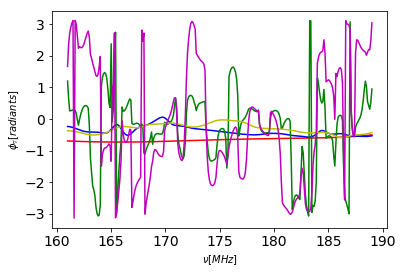

In [7]:
c1=closure_phase(path_to_rand+'30_rand_original_beam_full.ms',triad)
c2=closure_phase(path_to_rand+'30_artificial_mutual_port_22_complex_full.ms',triad)
c3=closure_phase(path_to_rand+'30_artificial_mutual_port_46_complex_full.ms',triad)
c4=closure_phase(path_to_rand+'30_artificial_mutual_port_46_complex_full.ms',triad3)
c5=closure_phase(path_to_rand+'30_artificial_mutual_port_22_complex_full.ms',triad2)

freq=np.linspace(161,189,280)
plt.plot(freq,c1[0,628:908],'r',label='$\\triangledown_{AAA}$')
plt.plot(freq,c2[0,628:908],'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,c3[0,628:908],'g',label='$\\triangledown_{CEE}$')
plt.plot(freq,c4[0,628:908],'y',label='$\\triangledown_{EEE}$')
plt.plot(freq,c5[0,628:908],'m',label='$\\triangledown_{ECC}$')
#plt.legend()
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex_full.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/20_random_distributed_sources/30_artificial_mutual_port_22_complex_outer.ms: 25 columns, 82680 rows


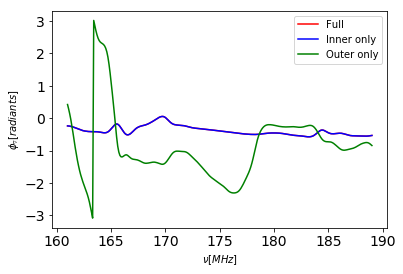

In [8]:
c1=closure_phase(path_to_rand+'30_artificial_mutual_port_22_complex_full.ms',triad)
c2=closure_phase(path_to_rand+'30_artificial_mutual_port_22_complex.ms',triad)
c3=closure_phase(path_to_rand+'30_artificial_mutual_port_22_complex_outer.ms',triad)

freq=np.linspace(161,189,280)
plt.plot(freq,c1[0,628:908],'r',label='Full')
plt.plot(freq,c2[0,628:908],'b',label='Inner only')
plt.plot(freq,c3[0,628:908],'g',label='Outer only')
plt.legend()
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")
plt.savefig("Fig_1.png",dpi=100)

## Two sky model

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_1_flux_100_pur_beam.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_10_flux_100_pur_beam.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_100_flux_100_pur_beam.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_1000_flux_100_pur_beam.ms: 25 columns, 82680 rows


Text(0,0.5,'$\\phi_{\\triangledown}[radiants]$')

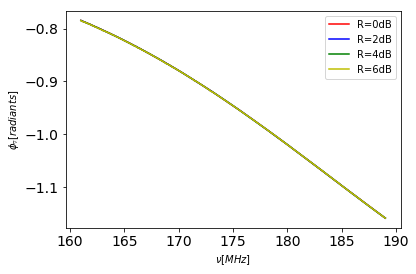

In [7]:
path_to_two='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/'
triad=[0,1,12]
c1=closure_phase(path_to_two+'rel_1_flux_100_pur_beam.ms',triad)
c2=closure_phase(path_to_two+'rel_10_flux_100_pur_beam.ms',triad)
c3=closure_phase(path_to_two+'rel_100_flux_100_pur_beam.ms',triad)
c4=closure_phase(path_to_two+'rel_1000_flux_100_pur_beam.ms',triad)

freq=np.linspace(161,189,280)
plt.plot(freq,c1[0,628:908],'r',label='R=0dB')
plt.plot(freq,c2[0,628:908],'b',label='R=2dB')
plt.plot(freq,c3[0,628:908],'g',label='R=4dB')
plt.plot(freq,c4[0,628:908],'y',label='R=6dB')

plt.legend()
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_1_flux_100_pur_beam.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_1_flux_100_pur_beam.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_10_flux_100_pur_beam.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_10_flux_100_pur_beam.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_100_flux_100_pur_beam.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_

Text(0,0.5,'$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$')

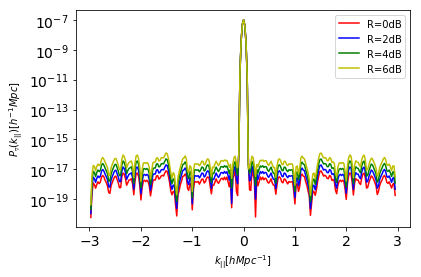

In [7]:
path_to_two='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/'
triad=[0,1,12]
d1=Delay_finder2(path_to_two+'rel_1_flux_100_pur_beam.ms',triad,d_band='High_band')
d2=Delay_finder2(path_to_two+'rel_10_flux_100_pur_beam.ms',triad,d_band='High_band')
d3=Delay_finder2(path_to_two+'rel_100_flux_100_pur_beam.ms',triad,d_band='High_band')
d4=Delay_finder2(path_to_two+'rel_1000_flux_100_pur_beam.ms',triad,d_band='High_band')

k_par,Power=Power_spectrum(d1[0],d1[1],"High_band")
k_par2,Power2=Power_spectrum(d2[0],d2[1],"High_band")
k_par3,Power3=Power_spectrum(d3[0],d3[1],"High_band")
k_par4,Power4=Power_spectrum(d4[0],d4[1],"High_band")
plt.semilogy(k_par,Power,'r',label='R=0dB')
plt.semilogy(k_par2,Power2,'b',label='R=2dB')
plt.semilogy(k_par3,Power3,'g',label='R=4dB')
plt.semilogy(k_par4,Power4,'y',label='R=6dB')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_1_flux_100_pur_beam_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_1_flux_100_pur_beam_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_10_flux_100_pur_beam_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_10_flux_100_pur_beam_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_100_flux_100_pur_beam_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/

Text(0,0.5,'$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$')

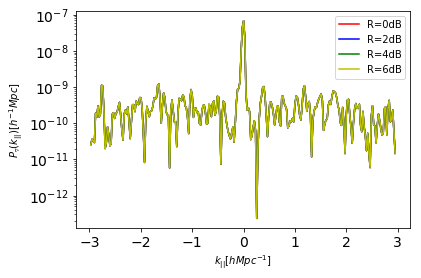

In [16]:
path_to_two='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/'
triad=[0,1,12]
d1=Delay_finder2(path_to_two+'rel_1_flux_100_pur_beam_outer.ms',triad,d_band='High_band')
d2=Delay_finder2(path_to_two+'rel_10_flux_100_pur_beam_outer.ms',triad,d_band='High_band')
d3=Delay_finder2(path_to_two+'rel_100_flux_100_pur_beam_outer.ms',triad,d_band='High_band')
d4=Delay_finder2(path_to_two+'rel_1000_flux_100_pur_beam_outer.ms',triad,d_band='High_band')

k_par,Power=Power_spectrum(d1[0],d1[1],"High_band")
k_par2,Power2=Power_spectrum(d2[0],d2[1],"High_band")
k_par3,Power3=Power_spectrum(d3[0],d3[1],"High_band")
k_par4,Power4=Power_spectrum(d4[0],d4[1],"High_band")
plt.semilogy(k_par,Power,'r',label='R=0dB')
plt.semilogy(k_par2,Power2,'b',label='R=2dB')
plt.semilogy(k_par3,Power3,'g',label='R=4dB')
plt.semilogy(k_par3,Power4,'y',label='R=6dB')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$")


Text(0,0.5,'$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$')

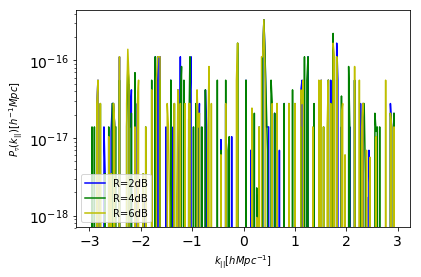

In [21]:
k_par,Power=Power_spectrum(d1[0],d1[1],"High_band")
k_par2,Power2=Power_spectrum(d2[0],d2[1],"High_band")
k_par3,Power3=Power_spectrum(d3[0],d3[1],"High_band")
k_par4,Power4=Power_spectrum(d4[0],d4[1],"High_band")
#plt.semilogy(k_par,Power-Power,'r',label='R=0dB')
plt.semilogy(k_par2,Power2-Power,'b',label='R=2dB')
plt.semilogy(k_par3,Power3-Power,'g',label='R=4dB')
plt.semilogy(k_par3,Power4-Power,'y',label='R=6dB')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_1_flux_100_pur_beam_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_10_flux_100_pur_beam_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_100_flux_100_pur_beam_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_1000_flux_100_pur_beam_outer.ms: 25 columns, 82680 rows


Text(0,0.5,'$\\phi_{\\triangledown}[radiants]$')

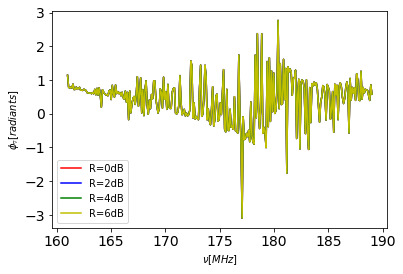

In [17]:
path_to_two='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/'
triad=[0,1,12]
c1=closure_phase(path_to_two+'rel_1_flux_100_pur_beam_outer.ms',triad)
c2=closure_phase(path_to_two+'rel_10_flux_100_pur_beam_outer.ms',triad)
c3=closure_phase(path_to_two+'rel_100_flux_100_pur_beam_outer.ms',triad)
c4=closure_phase(path_to_two+'rel_1000_flux_100_pur_beam_outer.ms',triad)

freq=np.linspace(161,189,280)
plt.plot(freq,c1[0,628:908],'r',label='R=0dB')
plt.plot(freq,c2[0,628:908],'b',label='R=2dB')
plt.plot(freq,c3[0,628:908],'g',label='R=4dB')
plt.plot(freq,c4[0,628:908],'y',label='R=6dB')

plt.legend()
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_1_flux_100_pur_beam_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_1_flux_100_pur_beam_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_10_flux_100_pur_beam_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_10_flux_100_pur_beam_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_100_flux_100_pur_beam_outer.ms: 25 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/

Text(0,0.5,'$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$')

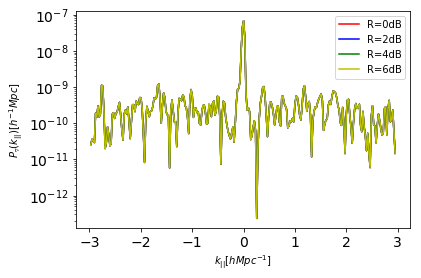

In [18]:
path_to_two='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/'
triad=[0,1,12]
d1=Delay_finder2(path_to_two+'rel_1_flux_100_pur_beam_outer.ms',triad,d_band='High_band')
d2=Delay_finder2(path_to_two+'rel_10_flux_100_pur_beam_outer.ms',triad,d_band='High_band')
d3=Delay_finder2(path_to_two+'rel_100_flux_100_pur_beam_outer.ms',triad,d_band='High_band')
d4=Delay_finder2(path_to_two+'rel_1000_flux_100_pur_beam_outer.ms',triad,d_band='High_band')

k_par,Power=Power_spectrum(d1[0],d1[1],"High_band")
k_par2,Power2=Power_spectrum(d2[0],d2[1],"High_band")
k_par3,Power3=Power_spectrum(d3[0],d3[1],"High_band")
k_par4,Power4=Power_spectrum(d4[0],d4[1],"High_band")
plt.semilogy(k_par,Power,'r',label='R=0dB')
plt.semilogy(k_par2,Power2,'b',label='R=2dB')
plt.semilogy(k_par3,Power3,'g',label='R=4dB')
plt.semilogy(k_par4,Power4,'y',label='R=6dB')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_1_flux.ms: 24 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_1_flux.ms: 24 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_1_flux.ms: 24 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_10_flux.ms: 24 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_10_flux.ms: 24 columns, 82680 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/rel_10_flux.ms: 24 columns, 82680 rows
S

Text(0,0.5,'$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$')

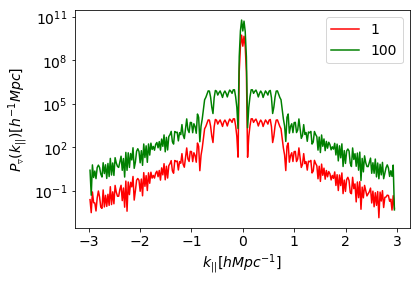

In [39]:
path_to_two='/vault-ike/ntsikelelo/simulated_ms_files/Artificial_sky_models/2_source_models/'
triad=[0,1,12]
# d1=Delay_finder2(path_to_two+'rel_1_flux.ms',triad,d_band='High_band')
# d2=Delay_finder2(path_to_two+'rel_10_flux.ms',triad,d_band='High_band')
# d3=Delay_finder2(path_to_two+'rel_100_flux.ms',triad,d_band='High_band')
# d4=Delay_finder2(path_to_two+'rel_1000_flux.ms',triad,d_band='High_band')

k_par,Power=Power_Spectrum_Jy(path_to_two+'rel_1_flux.ms',triad)
k_par2,Power2=Power_Spectrum_Jy(path_to_two+'rel_10_flux.ms',triad)
k_par3,Power3=Power_Spectrum_Jy(path_to_two+'rel_100_flux.ms',triad)
k_par4,Power4=Power_Spectrum_Jy(path_to_two+'rel_1000_flux.ms',triad)
plt.semilogy(k_par,np.abs(Power-Power2),'r',label='1')
# plt.semilogy(k_par2,Power2,'b',label='10')
plt.semilogy(k_par3,np.abs(Power-Power3),'g',label='100')
# plt.semilogy(k_par4,Power4,'y',label='1000')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$")

## Diffuse Emission

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_original_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_port22_high_band_diffuse.ms: 24 columns, 90 rows


Text(0,0.5,'$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$')

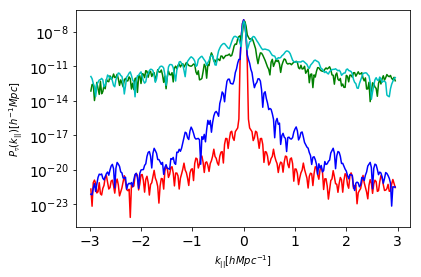

In [6]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad=[0,1,2]
triad2=[3,4,5]
d1=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_1h_original_high_band_diffuse.ms',triad,d_band='High_band')
d2=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port22_high_band_diffuse.ms',triad,d_band='High_band')
d3=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms',triad,d_band='High_band')
d4=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms',triad2,d_band='High_band')
d5=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port22_high_band_diffuse.ms',triad2,d_band='High_band')

k_par,Power=Power_spectrum(d1[0],d1[1],"High_band")
k_par2,Power2=Power_spectrum(d2[0],d2[1],"High_band")
k_par3,Power3=Power_spectrum(d3[0],d3[1],"High_band")
k_par4,Power4=Power_spectrum(d4[0],d4[1],"High_band")
k_par5,Power5=Power_spectrum(d5[0],d5[1],"High_band")

plt.semilogy(k_par,Power,'r',label='$\\triangledown_{AAA}$')
plt.semilogy(k_par2,Power2,'b',label='$\\triangledown_{CCC}$')
plt.semilogy(k_par3,Power3,'g',label='$\\triangledown_{CEE}$')
#plt.semilogy(k_par4,Power4,'y',label='$\\triangledown_{EEE}$')
plt.semilogy(k_par5,Power5,'c',label='$\\triangledown_{ECC}$')
# plt.semilogy(k_par4,(10*Power5+3*Power2+2*Power3)/15,'m',label='average')
#plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_original_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms: 24 columns, 90 row

Text(0,0.5,'$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$')

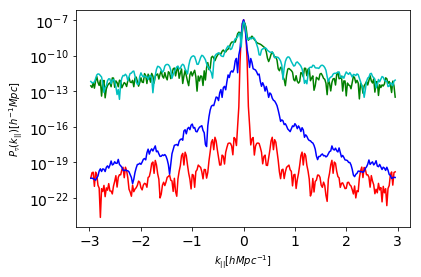

In [7]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad=[0,1,2]
triad2=[3,4,5]
d1=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_05h_original_high_band_diffuse.ms',triad,d_band='High_band')
d2=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms',triad,d_band='High_band')
d3=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms',triad,d_band='High_band')
d4=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms',triad2,d_band='High_band')
d5=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms',triad2,d_band='High_band')

k_par,Power=Power_spectrum(d1[0],d1[1],"High_band")
k_par2,Power2=Power_spectrum(d2[0],d2[1],"High_band")
k_par3,Power3=Power_spectrum(d3[0],d3[1],"High_band")
k_par4,Power4=Power_spectrum(d4[0],d4[1],"High_band")
k_par5,Power5=Power_spectrum(d5[0],d5[1],"High_band")

plt.semilogy(k_par,Power,'r',label='$\\triangledown_{AAA}$')
plt.semilogy(k_par2,Power2,'b',label='$\\triangledown_{CCC}$')
plt.semilogy(k_par3,Power3,'g',label='$\\triangledown_{CEE}$')
# plt.semilogy(k_par4,Power4,'y',label='$\\triangledown_{EEE}$')
plt.semilogy(k_par5,Power5,'c',label='$\\triangledown_{ECC}$')
# plt.semilogy(k_par4,(10*Power5+3*Power2+2*Power3)/15,'m',label='average')
#plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_original_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms: 24 columns, 90 rows


Text(0,0.5,'$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$')

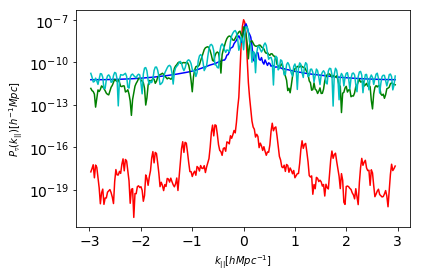

In [8]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad=[0,1,2]
triad2=[3,4,5]
d1=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_0h_original_high_band_diffuse.ms',triad,d_band='High_band')
d2=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms',triad,d_band='High_band')
d3=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms',triad,d_band='High_band')
d4=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms',triad2,d_band='High_band')
d5=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms',triad2,d_band='High_band')

k_par,Power=Power_spectrum(d1[0],d1[1],"High_band")
k_par2,Power2=Power_spectrum(d2[0],d2[1],"High_band")
k_par3,Power3=Power_spectrum(d3[0],d3[1],"High_band")
k_par4,Power4=Power_spectrum(d4[0],d4[1],"High_band")
k_par5,Power5=Power_spectrum(d5[0],d5[1],"High_band")

plt.semilogy(k_par,Power,'r',label='$\\triangledown_{AAA}$')
plt.semilogy(k_par2,Power2,'b',label='$\\triangledown_{CCC}$')
plt.semilogy(k_par3,Power3,'g',label='$\\triangledown_{CEE}$')
# plt.semilogy(k_par4,Power4,'y',label='$\\triangledown_{EEE}$')
plt.semilogy(k_par5,Power5,'c',label='$\\triangledown_{ECC}$')
# plt.semilogy(k_par4,(10*Power5+3*Power2+2*Power3)/15,'m',label='average')
#plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$")

## Power Spectrum Jy

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_original_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_original_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms: 24 columns, 90 rows
S

Text(0,0.5,'$P_{\\triangledown}(k_{||})$[pseudo Jy Hz]')

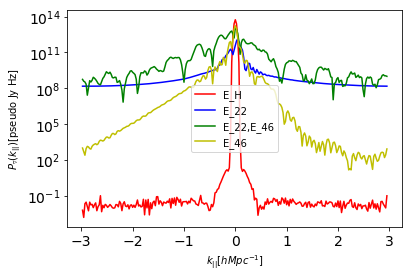

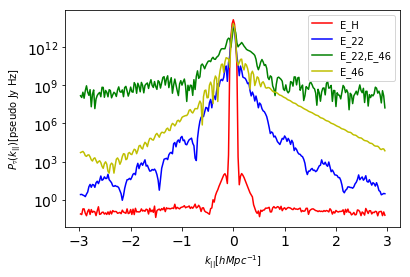

In [9]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad=[0,1,2]
triad2=[3,4,5] 
k_par,Power=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_0h_original_high_band_diffuse.ms',triad)
k_par,Power2=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms',triad)
k_par,Power3=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms',triad)
k_par,Power4=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms',triad2)


plt.semilogy(k_par,Power,'r',label='E_H')
plt.semilogy(k_par,Power2,'b',label='E_22')
plt.semilogy(k_par,Power3,'g',label='E_22,E_46')
plt.semilogy(k_par,Power4,'y',label='E_46')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo Jy Hz]")

path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad=[0,1,2]
triad2=[3,4,5] 
k_par,Power=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_05h_original_high_band_diffuse.ms',triad)
k_par,Power22=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms',triad)
k_par,Power3=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms',triad)
k_par,Power4=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms',triad2)

plt.figure()
plt.semilogy(k_par,Power,'r',label='E_H')
plt.semilogy(k_par,Power22,'b',label='E_22')
plt.semilogy(k_par,Power3,'g',label='E_22,E_46')
plt.semilogy(k_par,Power4,'y',label='E_46')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo Jy Hz]")


Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Suc

Text(0,0.5,'$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$')

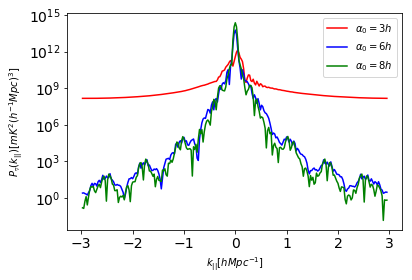

In [10]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad=[0,1,2]
triad2=[3,4,5] 
k_par,Power=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms',triad)
k_par,Power2=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms',triad)
k_par,Power3=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port22_high_band_diffuse.ms',triad)


plt.semilogy(k_par,Power,'r',label='$\\alpha_0=3h$')
plt.semilogy(k_par,Power2,'b',label='$\\alpha_0=6h$')
plt.semilogy(k_par,Power3,'g',label='$\\alpha_0=8h$')

plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Suc

Text(0,0.5,'$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$')

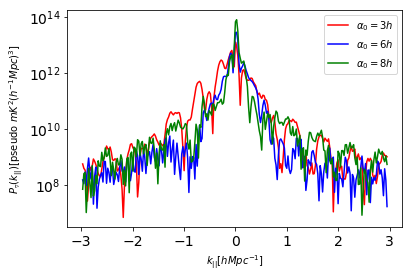

In [11]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad=[0,1,2]
triad2=[3,4,5] 
k_par,Power=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms',triad)
k_par,Power2=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms',triad)
k_par,Power3=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms',triad)


plt.semilogy(k_par,Power,'r',label='$\\alpha_0=3h$')
plt.semilogy(k_par,Power2,'b',label='$\\alpha_0=6h$')
plt.semilogy(k_par,Power3,'g',label='$\\alpha_0=8h$')

plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Suc

Text(0,0.5,'$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$')

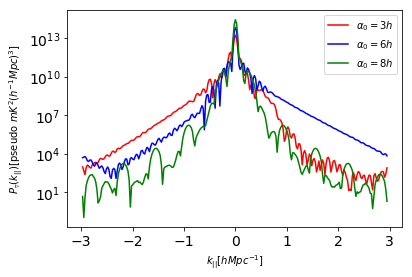

In [12]:
path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad=[0,1,2]
triad2=[3,4,5] 
k_par,Power=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms',triad2)
k_par,Power2=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms',triad2)
k_par,Power3=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms',triad2)



plt.semilogy(k_par,Power,'r',label='$\\alpha_0=3h$')
plt.semilogy(k_par,Power2,'b',label='$\\alpha_0=6h$')
plt.semilogy(k_par,Power3,'g',label='$\\alpha_0=8h$')

plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")

## Average closure spectra level

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_original_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Suc

Text(0,0.5,'$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$')

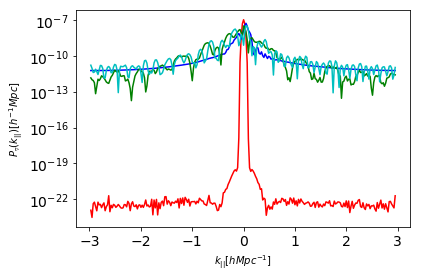

In [13]:
def closure_phase(msfile_used,triad_list): 
    import numpy as np
    from pyrap.tables import table
    
    msfile=table(msfile_used,readonly=True)
    data=msfile.getcol("DATA")[:,:,0]
    ant_i=msfile.getcol("ANTENNA1")
    ant_j=msfile.getcol("ANTENNA2")
    V_ij=data[bl_finder(ant_i,ant_j,triad_list[0],triad_list[1])]
    V_jk=data[bl_finder(ant_i,ant_j,triad_list[1],triad_list[2])]
    V_ki=np.conjugate(data[bl_finder(ant_i,ant_j,triad_list[0],triad_list[2])])
    closure_phase=np.angle(V_ij*V_jk*V_ki)
    return np.array(closure_phase)
def bl_finder (ant_i,ant_j,i,j):
        
           
           y=np.where((ant_i==i)&(ant_j==j))
        
           return y
        
def Delay_finder_average_closure(x1,x2):
    
    df=((200-100)/1024.0)*10**6
    d=signal.csd(np.exp(1.0j*x1),np.exp(1.0j*x2),fs=1/df,detrend=None,window="blackmanharris",scaling="spectrum")
    
    d_data=np.mean(d[1],axis=0)
    
    return np.fft.fftshift(d[0]),np.fft.fftshift(np.abs(d_data))*df
triad=[0,1,2]
triad2=[3,4,5]
c1=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_0h_original_high_band_diffuse.ms',triad)
c2=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms',triad)
c3=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms',triad)
c4=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms',triad2)
c5=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms',triad2)
c_av=(c2+c3+c5)/3

d_av=Delay_finder_average_closure(x1=c_av[0:3,:],x2=c_av[3:6,:])


path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'

d1=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_0h_original_high_band_diffuse.ms',triad,d_band='High_band')
d2=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms',triad,d_band='High_band')
d3=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms',triad,d_band='High_band')
d4=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms',triad2,d_band='High_band')
d5=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms',triad2,d_band='High_band')

k_par,Power=Power_spectrum(d1[0],d1[1],"High_band")
k_par2,Power2_1h=Power_spectrum(d2[0],d2[1],"High_band")
k_par3,Power3_1h=Power_spectrum(d3[0],d3[1],"High_band")
k_par4,Power4_1h=Power_spectrum(d4[0],d4[1],"High_band")
k_par5,Power5_1h=Power_spectrum(d5[0],d5[1],"High_band")
k_par_av,Power_av_cl_1h=Power_spectrum(d_av[0],d_av[1],"High_band")

P_av_1h=(10*Power5_1h+3*Power2_1h+2*Power3_1h)/15
plt.semilogy(k_par,Power,'r',label='$\\triangledown_{AAA}$')
plt.semilogy(k_par2,Power2_1h,'b',label='$\\triangledown_{CCC}$')
plt.semilogy(k_par3,Power3_1h,'g',label='$\\triangledown_{CEE}$')
# plt.semilogy(k_par4,Power4_1h,'g',label='$\\triangledown_{EEE}$')
plt.semilogy(k_par5,Power5_1h,'c',label='$\\triangledown_{ECC}$')
# plt.semilogy(k_par4,(10*Power5_1h+3*Power2_1h+2*Power3_1h)/15,'m',label='$\\bar P_{\\triangledown}$')
# plt.semilogy(k_par_av,Power_av_cl_1h,'k',label='${\\bar\\phi_{\\triangledown}}$')
# plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$")

Text(0,0.5,'$\\phi_{\\triangledown}[radiants]$')

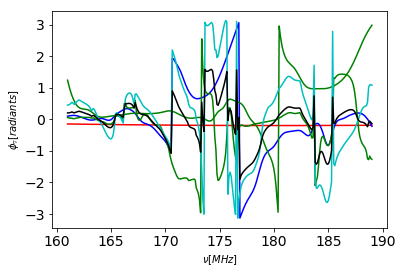

In [16]:
freq=np.linspace(161,189,280)
plt.plot(freq,c1[0,:],'r',label='$\\triangledown_{AAA}$')
plt.plot(freq,c2[0,:],'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,c3[0,:],'g',label='$\\triangledown_{CEE}$')
plt.plot(freq,c4[0,:],'g',label='$\\triangledown_{EEE}$')
plt.plot(freq,c5[0,:],'c',label='$\\triangledown_{ECC}$')
plt.plot(freq,c_av[0,:],'k',label='${\\bar\\phi_{\\triangledown}}$')
#plt.legend()
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

Text(0,0.5,'$\\phi_{\\triangledown}[radiants]$')

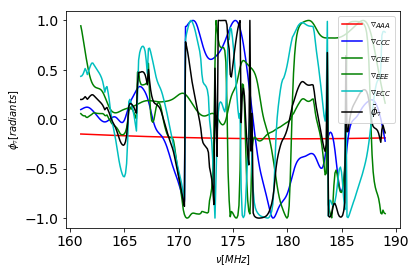

In [30]:
freq=np.linspace(161,189,280)
plt.plot(freq,np.imag(np.exp(1j*c1[0,:])),'r',label='$\\triangledown_{AAA}$')
plt.plot(freq,np.imag(np.exp(1j*c2[0,:])),'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,np.imag(np.exp(1j*c3[0,:])),'g',label='$\\triangledown_{CEE}$')
plt.plot(freq,np.imag(np.exp(1j*c4[0,:])),'g',label='$\\triangledown_{EEE}$')
plt.plot(freq,np.imag(np.exp(1j*c5[0,:])),'c',label='$\\triangledown_{ECC}$')
plt.plot(freq,np.imag(np.exp(1j*c_av[0,:])),'k',label='${\\bar\\phi_{\\triangledown}}$')
plt.legend()
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_original_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms: 24 columns, 90 row

Text(0,0.5,'$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$')

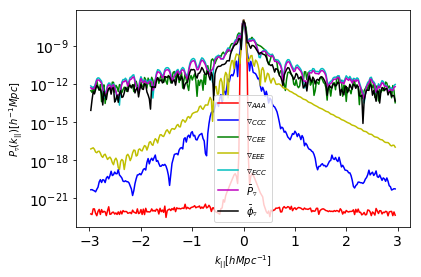

In [11]:
c1=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_05h_original_high_band_diffuse.ms',triad)
c2=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms',triad)
c3=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms',triad)
c4=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms',triad2)
c5=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms',triad2)
c_av=(c2+c3+c5)/3

d_av=Delay_finder_average_closure(x1=c_av[0:3,:],x2=c_av[3:6,:])


path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad=[0,1,2]
triad2=[3,4,5]
d1=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_05h_original_high_band_diffuse.ms',triad,d_band='High_band')
d2=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms',triad,d_band='High_band')
d3=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms',triad,d_band='High_band')
d4=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms',triad2,d_band='High_band')
d5=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms',triad2,d_band='High_band')

k_par,Power=Power_spectrum(d1[0],d1[1],"High_band")
k_par2,Power2_2h=Power_spectrum(d2[0],d2[1],"High_band")
k_par3,Power3_2h=Power_spectrum(d3[0],d3[1],"High_band")
k_par4,Power4_2h=Power_spectrum(d4[0],d4[1],"High_band")
k_par5,Power5_2h=Power_spectrum(d5[0],d5[1],"High_band")
k_par_av,Power_av_cl_2h=Power_spectrum(d_av[0],d_av[1],"High_band")

P_av_2h=(10*Power5_2h+3*Power2_2h+2*Power3_2h)/15
plt.semilogy(k_par,Power,'r',label='$\\triangledown_{AAA}$')
plt.semilogy(k_par2,Power2_2h,'b',label='$\\triangledown_{CCC}$')
plt.semilogy(k_par3,Power3_2h,'g',label='$\\triangledown_{CEE}$')
plt.semilogy(k_par4,Power4_2h,'y',label='$\\triangledown_{EEE}$')
plt.semilogy(k_par5,Power5_2h,'c',label='$\\triangledown_{ECC}$')
plt.semilogy(k_par4,P_av_2h,'m',label='$\\bar P_{\\triangledown}$')
plt.semilogy(k_par_av,Power_av_cl_2h,'k',label='${\\bar\\phi_{\\triangledown}}$')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$")

Text(0,0.5,'$\\phi_{\\triangledown}[radiants]$')

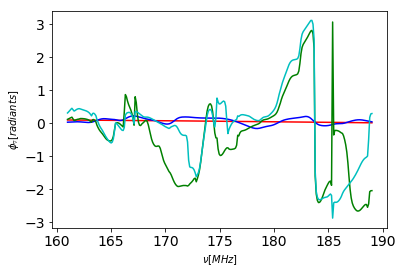

In [12]:
freq=np.linspace(161,189,280)
plt.plot(freq,c1[0,:],'r',label='$\\triangledown_{AAA}$')
plt.plot(freq,c2[0,:],'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,c3[0,:],'g',label='$\\triangledown_{CEE}$')
# plt.plot(freq,c4[0,:],'y',label='$\\triangledown_{EEE}$')
plt.plot(freq,c5[0,:],'c',label='$\\triangledown_{ECC}$')
#plt.plot(freq,c_av[0,:],'k',label='${\\bar\\phi_{\\triangledown}}$')
#plt.legend()
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_original_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Suc

Text(0,0.5,'$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$')

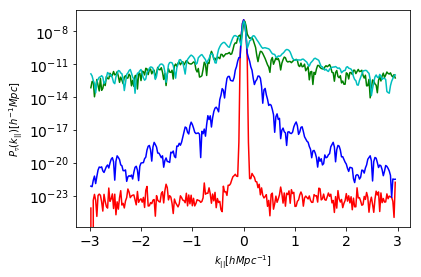

In [20]:
c1=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_1h_original_high_band_diffuse.ms',triad)
c2=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port22_high_band_diffuse.ms',triad)
c3=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms',triad)
c4=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms',triad2)
c5=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port22_high_band_diffuse.ms',triad2)
c_av=(c2+c3+c5)/3

d_av=Delay_finder_average_closure(x1=c_av[0:3,:],x2=c_av[3:6,:])


path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'
triad=[0,1,2]
triad2=[3,4,5]
d1=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_1h_original_high_band_diffuse.ms',triad,d_band='High_band')
d2=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port22_high_band_diffuse.ms',triad,d_band='High_band')
d3=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms',triad,d_band='High_band')
d4=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms',triad2,d_band='High_band')
d5=Delay_finder(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port22_high_band_diffuse.ms',triad2,d_band='High_band')

k_par,Power=Power_spectrum(d1[0],d1[1],"High_band")
k_par2,Power2_3h=Power_spectrum(d2[0],d2[1],"High_band")
k_par3,Power3_3h=Power_spectrum(d3[0],d3[1],"High_band")
k_par4,Power4_3h=Power_spectrum(d4[0],d4[1],"High_band")
k_par5,Power5_3h=Power_spectrum(d5[0],d5[1],"High_band")
k_par_av,Power_av_cl_3h=Power_spectrum(d_av[0],d_av[1],"High_band")

P_av_3h=(10*Power5_3h+3*Power2_3h+2*Power3_3h)/15
plt.semilogy(k_par,Power,'r',label='$\\triangledown_{AAA}$')
plt.semilogy(k_par2,Power2_3h,'b',label='$\\triangledown_{CCC}$')
plt.semilogy(k_par3,Power3_3h,'g',label='$\\triangledown_{CEE}$')
# plt.semilogy(k_par4,Power4_3h,'y',label='$\\triangledown_{EEE}$')
plt.semilogy(k_par5,Power5_3h,'c',label='$\\triangledown_{ECC}$')
# plt.semilogy(k_par4,(10*Power5_3h+3*Power2_3h+2*Power3_3h)/15,'m',label='$\\bar P_{\\triangledown}$')
# plt.semilogy(k_par_av,Power_av_cl_3h,'k',label='${\\bar\\phi_{\\triangledown}}$')
# plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})[h^{-1} Mpc]$")

Text(0,0.5,'$\\phi_{\\triangledown}[radiants]$')

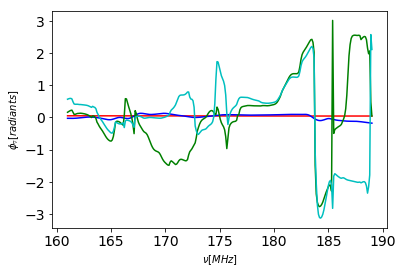

In [24]:
freq=np.linspace(161,189,280)
plt.plot(freq,c1[0,:],'r',label='$\\triangledown_{AAA}$')
plt.plot(freq,c2[0,:],'b',label='$\\triangledown_{CCC}$')
plt.plot(freq,c3[0,:],'g',label='$\\triangledown_{CEE}$')
#plt.plot(freq,c4[0,:],'y',label='$\\triangledown_{EEE}$')
plt.plot(freq,c5[0,:],'c',label='$\\triangledown_{ECC}$')
#plt.plot(freq,c_av[0,:],'k',label='${\\bar\\phi_{\\triangledown}}$')
#plt.legend()
plt.xlabel("$\\nu [MHz]$")
plt.ylabel("$\\phi_{\\triangledown}[radiants]$")

# Power spectrum average over fields

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_original_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Suc

(0.001, 1000000000000000)

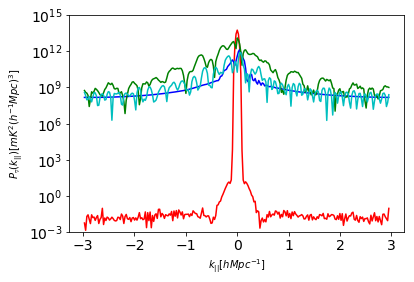

In [22]:
def Power_Spectrum_Jy_2_average(msfile_used, triad_list,delay):
    from scipy import signal
    
    
    msfile=table(msfile_used,readonly=True)
    data=msfile.getcol("DATA")[:,:,0]
    ant_i=msfile.getcol("ANTENNA1")
    ant_j=msfile.getcol("ANTENNA2")
    V_ij=data[bl_finder(ant_i,ant_j,triad_list[0],triad_list[1])][0,:] # visibilities
    V_jk=data[bl_finder(ant_i,ant_j,triad_list[1],triad_list[2])][0,:]
    V_ki=np.conjugate(data[bl_finder(ant_i,ant_j,triad_list[0],triad_list[2])])[0,:]
    window = signal.blackmanharris(280)
    df=((200-100)/1024.0)*10**6
    
    V_ij_f=np.trapz(y=V_ij*window, dx=df)/(np.trapz(y=window,dx=df)) 
    V_jk_f=np.trapz(y=V_jk*window, dx=df)/(np.trapz(y=window,dx=df)) 
    V_ki_f=np.trapz(y=V_ki*window, dx=df)/(np.trapz(y=window,dx=df)) 


    V_eff=(np.abs(V_ij_f**(-2))+np.abs(V_jk_f**(-2))+np.abs(V_ki_f**(-2)))**(-0.5)


    A_eff=100.0
    f_12=1420.4
    k_b=1.38064852*10**(-23)
    freq_data=np.linspace(100,200,1024)
    F_175_Hz=175.0*10**6
    c=3.0*10**8
    lambda_175=F_175_Hz/c

    z=np.abs((freq_data[768]-f_12)/freq_data[768]) 


    B_eff=np.trapz(y=window,dx=df)
    H0=cosmo.H0
    base_line=14.6
    theta=(lambda_175/base_line)
    D=cosmo.comoving_transverse_distance(z=z)*theta
    constant=(A_eff/(lambda_175**2*B_eff))*((D**2*Delta_D(z))/B_eff)*((lambda_175**2)/(2*k_b))**2




    d1=delay
    phi=d1[1]*V_eff
    phi_Joule=phi*10**(-26)
    Power_K=phi_Joule*constant
    Power_mK=Power_K*10**(-6)
    k_par=k_II(d1[0],B_eff,z,H0)
    return k_par,Power_mK



triad=[0,1,2]
triad2=[3,4,5]
c1=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_0h_original_high_band_diffuse.ms',triad)
c2=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms',triad)
c3=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms',triad)
c4=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms',triad2)
c5=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms',triad2)
c_av=(c2+c3+c5)/3

d_av=Delay_finder_average_closure(x1=c_av[0:3,:],x2=c_av[3:6,:])


path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'

k_par,Power=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_0h_original_high_band_diffuse.ms',triad)
k_par2,Power2_1h=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms',triad)
k_par3,Power3_1h=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms',triad)
k_par4,Power4_1h=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port46_high_band_diffuse.ms',triad2)
k_par5,Power5_1h=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_0h_port22_high_band_diffuse.ms',triad2)
k_par_av,Power_av_cl_1h=Power_Spectrum_Jy_2_average(path_to_GLEAM+'GLEAM_200mJy_LST_0h_original_high_band_diffuse.ms',triad,d_av)

P_av_1h=(10*Power5_1h+3*Power2_1h+2*Power3_1h)/15
plt.semilogy(k_par,Power,'r',label='$\\triangledown_{AAA}$')
plt.semilogy(k_par2,Power2_1h,'b',label='$\\triangledown_{CCC}$')
plt.semilogy(k_par3,Power3_1h,'g',label='$\\triangledown_{CEE}$')
# plt.semilogy(k_par4,Power4_1h,'y',label='$\\triangledown_{EEE}$')
plt.semilogy(k_par5,Power5_1h,'c',label='$\\triangledown_{ECC}$')
# plt.semilogy(k_par4,P_av_1h,'m',label='$\\bar P_{\\triangledown}$')
# plt.semilogy(k_par_av,Power_av_cl_1h,'k',label='${\\bar\\phi_{\\triangledown}}$')
# plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([10**-3,10**15])

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_original_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms: 24 columns, 90 row

(0.001, 1000000000000000)

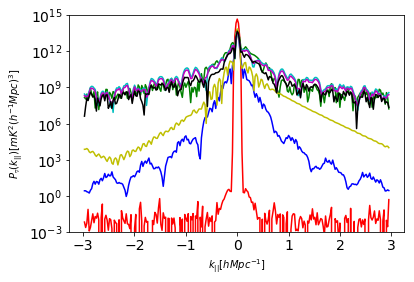

In [28]:
triad=[0,1,2]
triad2=[3,4,5]
c1=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_05h_original_high_band_diffuse.ms',triad)
c2=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms',triad)
c3=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms',triad)
c4=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms',triad2)
c5=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms',triad2)
c_av=(c2+c3+c5)/3

d_av=Delay_finder_average_closure(x1=c_av[0:3,:],x2=c_av[3:6,:])


path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'

k_par,Power=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_1h_original_high_band_diffuse.ms',triad)
k_par2,Power2_2h=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms',triad)
k_par3,Power3_2h=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms',triad)
k_par4,Power4_2h=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port46_high_band_diffuse.ms',triad2)
k_par5,Power5_2h=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_05h_port22_high_band_diffuse.ms',triad2)
k_par_av,Power_av_cl_2h=Power_Spectrum_Jy_2_average(path_to_GLEAM+'GLEAM_200mJy_LST_0h_original_high_band_diffuse.ms',triad,d_av)

P_av_2h=(10*Power5_2h+3*Power2_2h+2*Power3_2h)/15
plt.semilogy(k_par,Power,'r',label='$\\triangledown_{AAA}$')
plt.semilogy(k_par2,Power2_2h,'b',label='$\\triangledown_{CCC}$')
plt.semilogy(k_par3,Power3_2h,'g',label='$\\triangledown_{CEE}$')
plt.semilogy(k_par4,Power4_2h,'y',label='$\\triangledown_{EEE}$')
plt.semilogy(k_par5,Power5_2h,'c',label='$\\triangledown_{ECC}$')
plt.semilogy(k_par4,P_av_2h,'m',label='$\\bar P_{\\triangledown}$')
plt.semilogy(k_par_av,Power_av_cl_2h,'k',label='${\\bar\\phi_{\\triangledown}}$')
#plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([10**-3,10**15])

Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_original_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms: 24 columns, 90 rows
Successful readonly open of default-locked table /vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/GLEAM_200mJy_LST_1h_port22_high_band_diffuse.ms: 24 columns, 90 rows
Suc

(0.001, 1000000000000000)

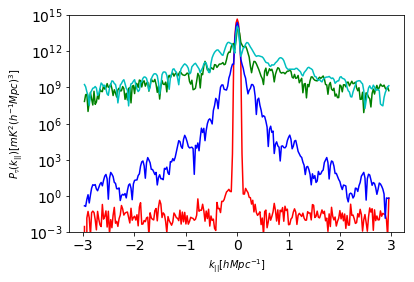

In [25]:
triad=[0,1,2]
triad2=[3,4,5]
c1=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_1h_original_high_band_diffuse.ms',triad)
c2=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port22_high_band_diffuse.ms',triad)
c3=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms',triad)
c4=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms',triad2)
c5=closure_phase(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port22_high_band_diffuse.ms',triad2)
c_av=(c2+c3+c5)/3

d_av=Delay_finder_average_closure(x1=c_av[0:3,:],x2=c_av[3:6,:])


path_to_GLEAM='/vault-ike/ntsikelelo/simulated_ms_files/GLEAM_simulations_29_DD_gain_corruption/'

k_par,Power=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_1h_original_high_band_diffuse.ms',triad)
k_par2,Power2_3h=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port22_high_band_diffuse.ms',triad)
k_par3,Power3_3h=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms',triad)
k_par4,Power4_3h=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port46_high_band_diffuse.ms',triad2)
k_par5,Power5_3h=Power_Spectrum_Jy_2(path_to_GLEAM+'GLEAM_200mJy_LST_1h_port22_high_band_diffuse.ms',triad2)
k_par_av,Power_av_cl_3h=Power_Spectrum_Jy_2_average(path_to_GLEAM+'GLEAM_200mJy_LST_1h_original_high_band_diffuse.ms',triad,d_av)

P_av_3h=(10*Power5_3h+3*Power2_3h+2*Power3_3h)/15
plt.semilogy(k_par,Power,'r',label='$\\triangledown_{AAA}$')
plt.semilogy(k_par2,Power2_3h,'b',label='$\\triangledown_{CCC}$')
plt.semilogy(k_par3,Power3_3h,'g',label='$\\triangledown_{CEE}$')
# plt.semilogy(k_par4,Power4_3h,'y',label='$\\triangledown_{EEE}$')
plt.semilogy(k_par5,Power5_3h,'c',label='$\\triangledown_{ECC}$')
# plt.semilogy(k_par4,P_av_3h,'m',label='$\\bar P_{\\triangledown}$')
# plt.semilogy(k_par_av,Power_av_cl_3h,'k',label='${\\bar\\phi_{\\triangledown}}$')
# plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.ylim([10**-3,10**15])

Text(0,0.5,'$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$')

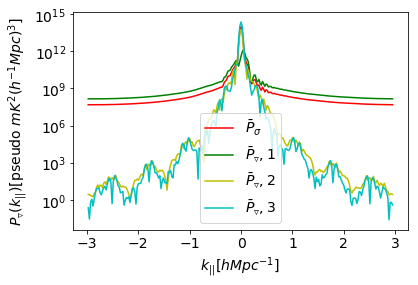

In [104]:
plt.semilogy(k_par2,(Power2_1h+Power2_2h+Power2_3h)/3,'r',label='$\\bar P_{\\sigma}$')
plt.semilogy(k_par4,Power2_1h,'g',label='$\\bar P_{\\triangledown},1$')
plt.semilogy(k_par_av,Power2_2h,'y',label='$\\bar P_{\\triangledown},2$')
plt.semilogy(k_par_av,Power2_3h,'c',label='$\\bar P_{\\triangledown},3$')


# plt.semilogy(k_par4,Power_av_cl_1h,'m',label='${\\bar\\phi_{\\triangledown}},1$')
# plt.semilogy(k_par_av,Power_av_cl_1h,'k',label='${\\bar\\phi_{\\triangledown}},2$')
# plt.semilogy(k_par_av,Power_av_cl_1h,'b',label='${\\bar\\phi_{\\triangledown}},3$')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")


Text(0,0.5,'$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$')

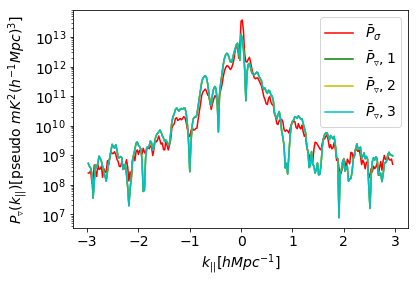

In [105]:
plt.semilogy(k_par2,(Power3_1h+Power3_2h+Power3_3h)/3,'r',label='$\\bar P_{\\sigma}$')
plt.semilogy(k_par4,Power3_1h,'g',label='$\\bar P_{\\triangledown},1$')
plt.semilogy(k_par_av,Power3_1h,'y',label='$\\bar P_{\\triangledown},2$')
plt.semilogy(k_par_av,Power3_1h,'c',label='$\\bar P_{\\triangledown},3$')
# plt.semilogy(k_par4,Power_av_cl_1h,'m',label='${\\bar\\phi_{\\triangledown}},1$')
# plt.semilogy(k_par_av,Power_av_cl_1h,'k',label='${\\bar\\phi_{\\triangledown}},2$')
# plt.semilogy(k_par_av,Power_av_cl_1h,'b',label='${\\bar\\phi_{\\triangledown}},3$')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")

Text(0,0.5,'$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$')

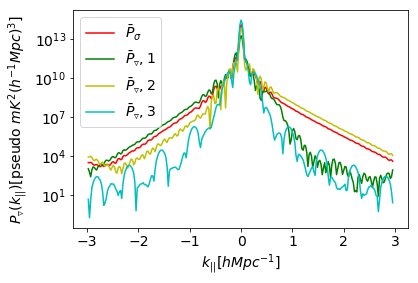

In [107]:
plt.semilogy(k_par2,(Power4_1h+Power4_2h+Power4_3h)/3,'r',label='$\\bar P_{\\sigma}$')
plt.semilogy(k_par4,Power4_1h,'g',label='$\\bar P_{\\triangledown},1$')
plt.semilogy(k_par_av,Power4_2h,'y',label='$\\bar P_{\\triangledown},2$')
plt.semilogy(k_par_av,Power4_3h,'c',label='$\\bar P_{\\triangledown},3$')
# plt.semilogy(k_par4,Power_av_cl_1h,'m',label='${\\bar\\phi_{\\triangledown}},1$')
# plt.semilogy(k_par_av,Power_av_cl_1h,'k',label='${\\bar\\phi_{\\triangledown}},2$')
# plt.semilogy(k_par_av,Power_av_cl_1h,'b',label='${\\bar\\phi_{\\triangledown}},3$')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")

Text(0,0.5,'$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$')

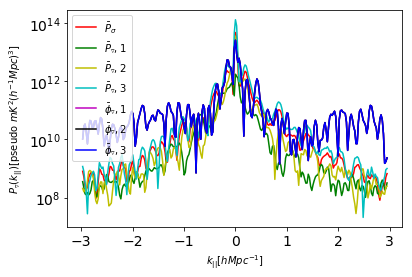

In [88]:
plt.semilogy(k_par2,(Power5_1h+Power5_2h+Power5_3h)/3,'r',label='$\\bar P_{\\sigma}$')
plt.semilogy(k_par4,P_av_1h,'g',label='$\\bar P_{\\triangledown},1$')
plt.semilogy(k_par_av,P_av_2h,'y',label='$\\bar P_{\\triangledown},2$')
plt.semilogy(k_par_av,P_av_3h,'c',label='$\\bar P_{\\triangledown},3$')
plt.semilogy(k_par4,Power_av_cl_1h,'m',label='${\\bar\\phi_{\\triangledown}},1$')
plt.semilogy(k_par_av,Power_av_cl_1h,'k',label='${\\bar\\phi_{\\triangledown}},2$')
plt.semilogy(k_par_av,Power_av_cl_1h,'b',label='${\\bar\\phi_{\\triangledown}},3$')
plt.legend()
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P_{\\triangledown}(k_{||})$[pseudo $mK^2 (h^{-1} Mpc)^3]$")